In [13]:
import os
import json
import warnings
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk

from collections import Counter
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import joblib

# Configuraci√≥n de semilla aleatoria para reproducibilidad
np.random.seed(42)
torch.manual_seed(42)

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pauci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pauci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pauci\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pauci\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# An√°lisis de Sentimientos en Rese√±as de M√∫sica üéµ

1. Carga Lectura y Exploraci√≥n de Datos

In [ ]:
data_path = r"C:\Users\pauci\Desktop\NLP\Project\reviews_Digital_Music_5.json\Digital_Music_5.json"

try:
    df = pd.read_json(data_path, lines=True)
except UnicodeDecodeError:
    df = pd.read_json(data_path, lines=True, encoding='utf-8-sig')

df = df[df['helpful'].apply(lambda x: x[1] >= 5)].reset_index(drop=True)
# El dataset de Amazon tiene una columna helpful con formato [n_utiles, n_votos_totales].
# Se filtra para que n_votos_totales >= 5. As√≠, te quedas con rese√±as donde al menos 5 personas votaron la utilidad.

In [9]:
# Mostrar las primeras filas del DataFrame

print(df.head())

       reviewerID        asin                               reviewerName  \
0  A2P49WD75WHAG5  5555991584                           Daniel J. Hamlow   
1  A3O90G1D7I5EGG  5555991584                                       dev1   
2  A3EJYJC25OJVKK  5555991584       Distant Voyageur "Nicholas Computer"   
3  A33TRNCQK4IUO7  5555991584                                 guillermoj   
4  A2AOZQ3WTNVVOK  5555991584  Lonnie E. Holder "The Review's the Thing"   

    helpful                                         reviewText  overall  \
0  [62, 65]  Who knows why I initially considered this to b...        5   
1    [1, 5]  Enya is one of a few artists whom I consider s...        3   
2    [5, 5]  Enya is one of of the most mysterious singers ...        5   
3  [12, 12]  Many times, AND WITH GOOD REASON, the "new age...        5   
4  [12, 13]  The problem with Enya is that she is so consis...        5   

                                             summary  unixReviewTime  \
0  Dreamy unearthly 

In [10]:
# An√°lisis b√°sico: se confirma cu√°ntas rese√±as hay de 1,2,3,4 y 5 estrellas

print("Total de rese√±as:", len(df))
print("\nDistribuci√≥n de ratings:")
rating_dist = df['overall'].value_counts().sort_index()
print(rating_dist)

Total de rese√±as: 18705

Distribuci√≥n de ratings:
overall
1    2017
2    1723
3    2386
4    3775
5    8804
Name: count, dtype: int64


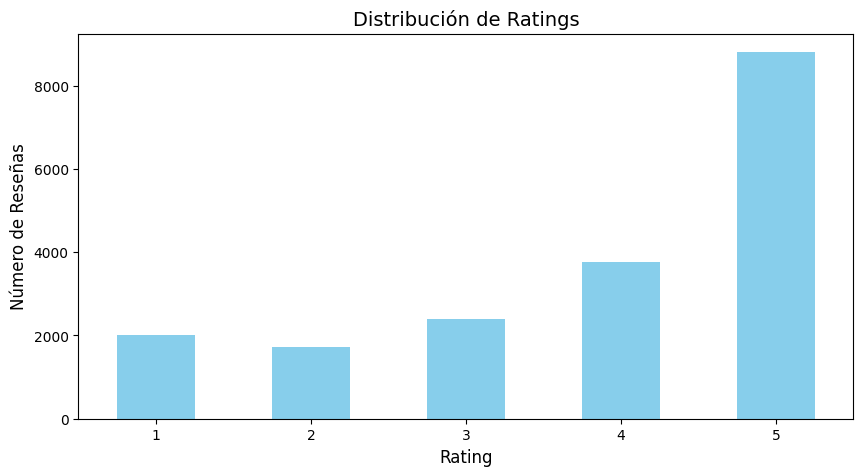

In [11]:
# Gr√°fico de distribuci√≥n de ratings: sesgo positivo en rese√±as (62.5% de ratings 4-5 estrellas)

plt.figure(figsize=(10,5))
rating_dist.plot(kind='bar', color='skyblue')
plt.title('Distribuci√≥n de Ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('N√∫mero de Rese√±as', fontsize=12)
plt.xticks(rotation=0)
plt.show()

In [12]:
# Cardinalidad del vocabulario antes del preprocesado

vocab = set()
for text in df['clean_text']:
    vocab.update(text.split())
print(f"\nCardinalidad del vocabulario: {len(vocab)} palabras")


Cardinalidad del vocabulario: 129134 palabras


In [14]:
# C√°lculo de rese√±as positivas y negativas (asumiendo >=4 como positivo)

df['sentiment'] = (df['overall'] >= 4).astype(int)
sentiment_counts = df['sentiment'].value_counts()
print(f"Rese√±as positivas (1): {sentiment_counts.get(1, 0)}")
print(f"Rese√±as negativas (0): {sentiment_counts.get(0, 0)}")

Rese√±as positivas (1): 12579
Rese√±as negativas (0): 6126


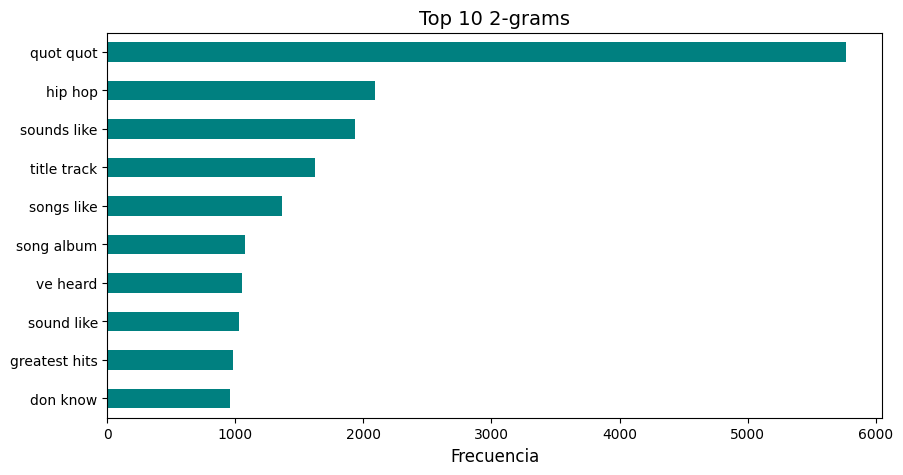

In [15]:
# N-grams m√°s frecuentes antes del preprocesado

def plot_top_ngrams(corpus, ngram_range=(2, 2), n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    ngrams = Counter(dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)))
    plt.figure(figsize=(10, 5))
    pd.Series(ngrams).nlargest(n).plot(kind='barh', color='teal')
    plt.title(f'Top {n} {ngram_range[0]}-grams', fontsize=14)
    plt.xlabel('Frecuencia', fontsize=12)
    plt.gca().invert_yaxis()
    plt.show()

plot_top_ngrams(df['reviewText'], (2, 2))

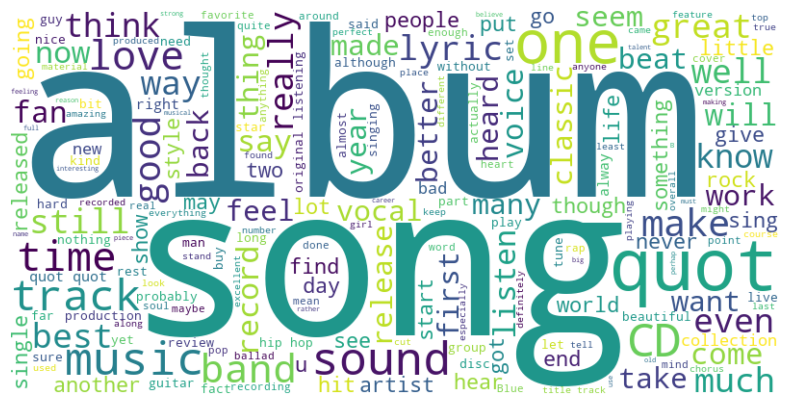

In [16]:
# Nube de palabras antes del preprocesado

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['reviewText']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Puntos Clave del Preprocesado

1. Inicializaci√≥n
- Lematizador: Se inicializa un lematizador (`WordNetLemmatizer`) para reducir palabras a su forma base.
- Stopwords: Se carga un conjunto de stopwords en ingl√©s para eliminar palabras comunes que no aportan significado.
- Cach√© de POS: Se crea un diccionario vac√≠o (`pos_cache`) para almacenar en cach√© las etiquetas POS y mejorar la eficiencia.

2. Conversi√≥n a Min√∫sculas
- Todo el texto se convierte a min√∫sculas para normalizarlo y evitar diferencias entre may√∫sculas y min√∫sculas.

3. Eliminaci√≥n de Caracteres Especiales
- Se eliminan todos los caracteres que no sean letras o espacios en blanco (n√∫meros, signos de puntuaci√≥n, etc.).

4. Normalizaci√≥n de Espacios en Blanco
- Se reemplazan m√∫ltiples espacios en blanco con un solo espacio y se eliminan los espacios al principio y al final del texto.

5. Tokenizaci√≥n
- El texto se divide en palabras individuales (tokens) usando `word_tokenize`.

6. Etiquetado de Partes del Discurso (POS Tagging)
- Se asigna a cada token su etiqueta POS (por ejemplo, "NN" para sustantivos, "VB" para verbos).

7. Lematizaci√≥n
- Cada palabra se reduce a su forma base (lema) usando la etiqueta POS correspondiente.
  - Ejemplo: "running" ‚Üí "run", "better" ‚Üí "good".

8. Filtrado de Palabras
- Se eliminan las palabras con menos de 3 caracteres y las stopwords (palabras comunes como "the", "and", "is").

9. Uni√≥n de Palabras Procesadas
- Las palabras procesadas se unen en una sola cadena separada por espacios.

10. Aplicaci√≥n del Preprocesado
- El m√©todo `clean_text` se aplica a cada fila de la columna `reviewText` del DataFrame, generando una nueva columna `clean_text` con el texto preprocesado.

In [31]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stopwords = set(stopwords.words('english'))
        self.pos_cache = {}

    def __get_wordnet_pos(self, treebank_tag):
        tag = treebank_tag[0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    def clean_text(self, text):
        if pd.isnull(text) or not isinstance(text, str):
            return ''
        text = text.lower()
        text = re.sub(r"[^a-zA-Z\s]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        tokens = word_tokenize(text)
        pos_tags = pos_tag(tokens)
        processed = []
        for word, tag in pos_tags:
            if len(word) > 2 and word not in self.stopwords:
                lemma = self.lemmatizer.lemmatize(word, self.__get_wordnet_pos(tag))
                processed.append(lemma)
        return ' '.join(processed)

preprocessor = TextPreprocessor()
df['clean_text'] = df['reviewText'].apply(preprocessor.clean_text)

# Entrenamiento del Modelo Word2Vec

Entrenamos un modelo de Word2Vec para generar embeddings de palabras a partir del texto preprocesado.

## Par√°metros

- **sentences**: Lista de textos tokenizados (cada texto se divide en palabras).
- **vector_size**: Dimensi√≥n de los embeddings (100 en este caso).
- **window**: Tama√±o de la ventana de contexto (5 palabras antes y despu√©s).
- **min_count**: Ignora palabras que aparecen menos de 10 veces.
- **workers**: N√∫mero de hilos para entrenar el modelo.
- **epochs**: N√∫mero de iteraciones sobre el corpus.

## Visualizaci√≥n

Se grafica las palabras m√°s similares a una palabra dada, bas√°ndose en los embeddings generados por Word2Vec.

### Par√°metros de Visualizaci√≥n

- **model**: Modelo Word2Vec entrenado.
- **word**: Palabra para la cual se buscan palabras similares.
- **topn**: N√∫mero de palabras similares a mostrar (10 por defecto).

## Funcionamiento

- Se obtienen las palabras m√°s similares y sus distancias coseno usando `model.wv.most_similar`.
- Se crea un gr√°fico de barras con las palabras y sus distancias.


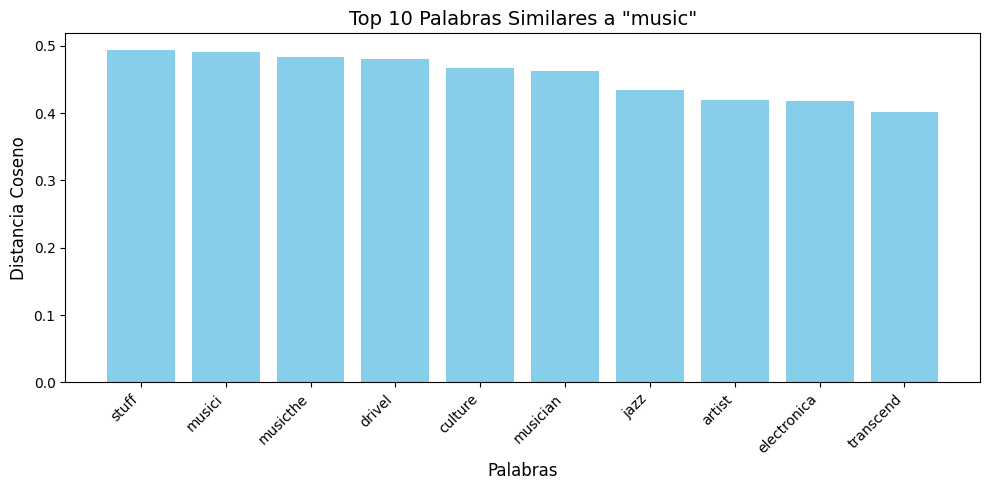

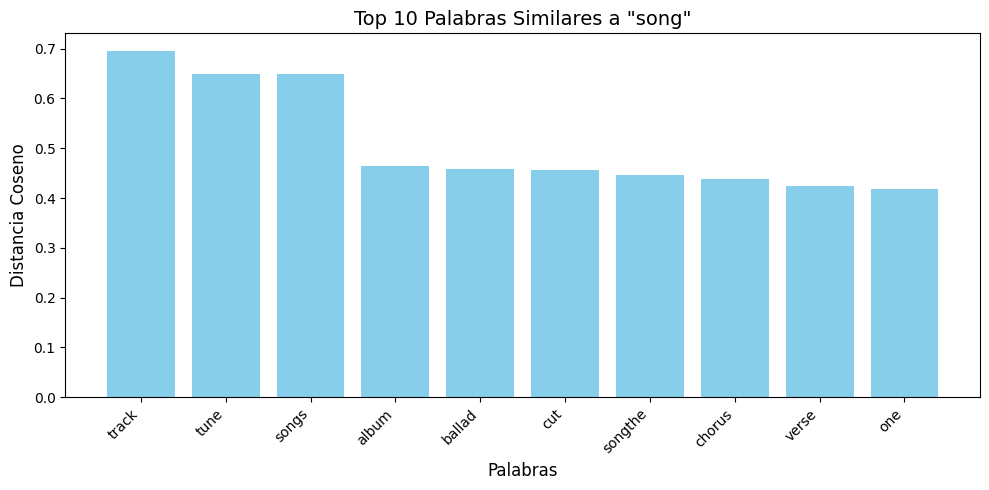

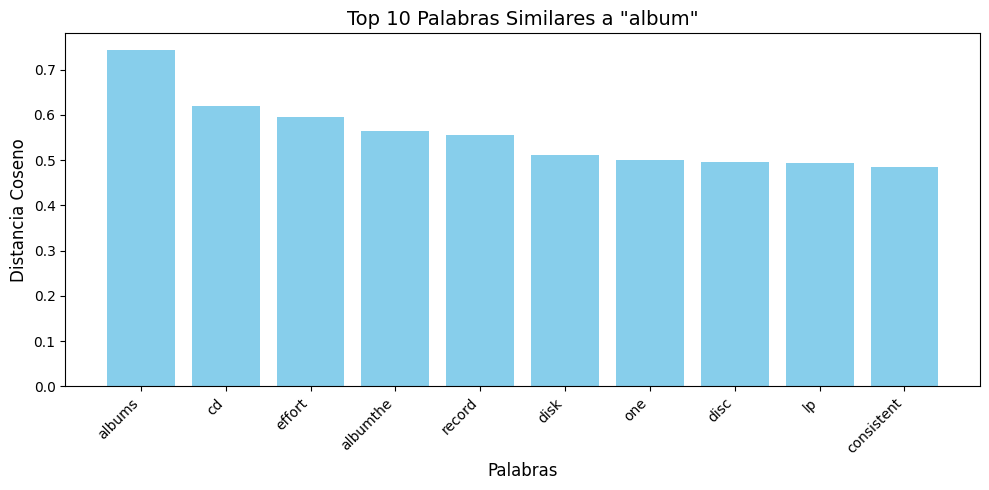

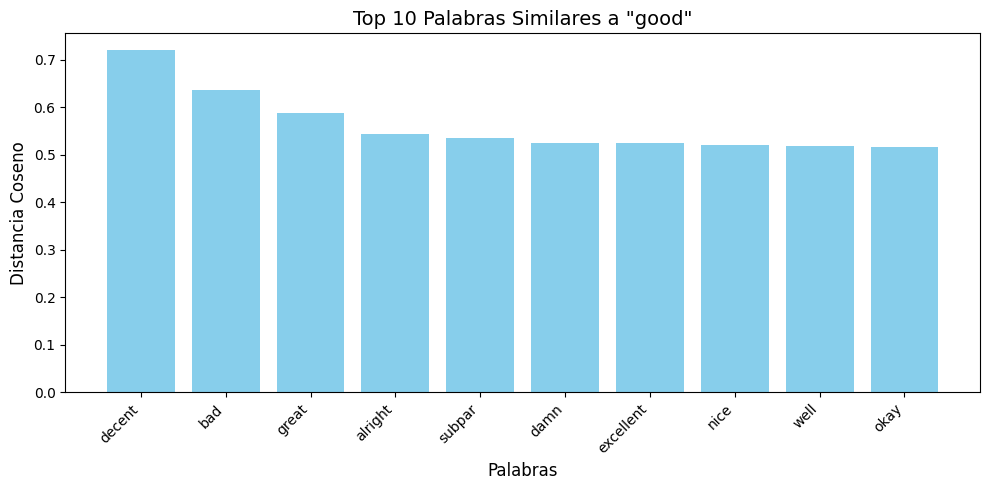

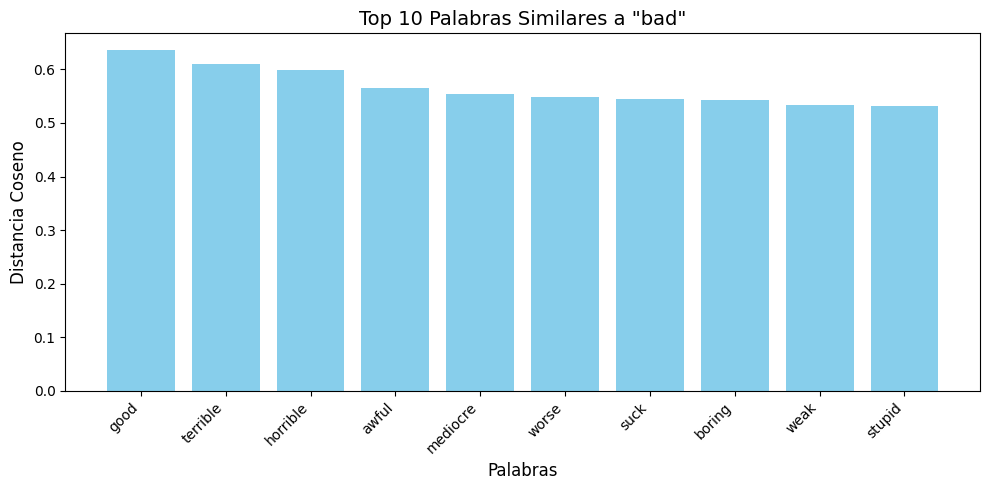

In [ ]:
# Word Embeddings y Visualizaciones

w2v_model = Word2Vec(sentences=[text.split() for text in df['clean_text']], vector_size=100, window=5, min_count=10, workers=4, epochs=10)

def plot_similar_words(model, word, topn=10):
    similar_words = model.wv.most_similar(word, topn=topn)
    words = [w[0] for w in similar_words]
    distances = [w[1] for w in similar_words]
    plt.figure(figsize=(10, 5))
    plt.bar(words, distances, color='skyblue')
    plt.title(f'Top {topn} Palabras Similares a "{word}"', fontsize=14)
    plt.xlabel('Palabras', fontsize=12)
    plt.ylabel('Distancia Coseno', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

words_to_plot = ['music', 'song', 'album', 'good', 'bad']
for word in words_to_plot:
    plot_similar_words(w2v_model, word)

# Visualizaci√≥n de Word Embeddings en 2D

Los embeddings generados por Word2Vec son de alta dimensionalidad (por ejemplo, 100 dimensiones). La t√©cnica **t-SNE** reduce estas dimensiones a 2D para facilitar la visualizaci√≥n, permitiendo representar relaciones complejas en un formato simple y comprensible.

## Detalles

- **Palabras Analizadas:** `['music', 'song', 'album', 'good', 'bad']`
- **Resultado:**  
  - Un gr√°fico en 2D donde se observa que:
    - "music", "song" y "album" aparecen cerca, indicando que est√°n relacionadas.
    - "good" y "bad" pueden aparecer en lados opuestos, reflejando su relaci√≥n antag√≥nica.


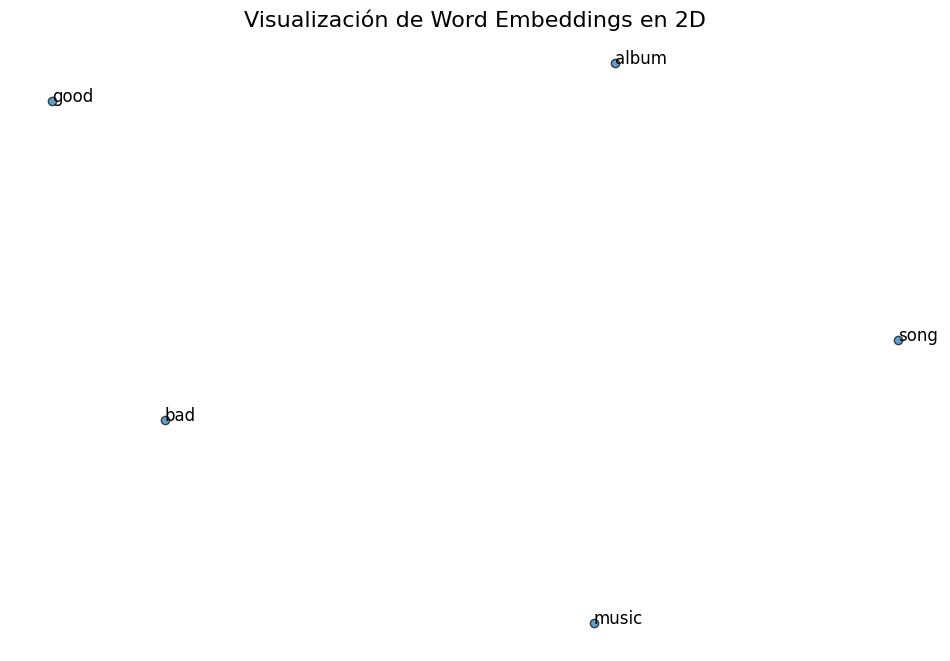

In [ ]:
# Visualizaci√≥n de Word Embeddings en 2D

def plot_word_embeddings(model, words):
    embeddings = np.array([model.wv[word] for word in words if word in model.wv])
    reduced = TSNE(n_components=2, perplexity=min(len(embeddings)-1, 5)).fit_transform(embeddings)
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced[:, 0], reduced[:, 1], edgecolor='k', alpha=0.7)
    for i, word in enumerate(words):
        if word in model.wv:
            plt.annotate(word, xy=(reduced[i, 0], reduced[i, 1]), fontsize=12)
    plt.title('Visualizaci√≥n de Word Embeddings en 2D', fontsize=16)
    plt.axis('off')
    plt.show()

words_to_plot = ['music', 'song', 'album', 'good', 'bad']
plot_word_embeddings(w2v_model, words_to_plot)

# 3. Etapa de Entrenamiento y Testeo de Modelos de An√°lisis de Sentimiento

## 1. **Conversi√≥n del Texto a Representaci√≥n Num√©rica (TF-IDF)**
   - **Prop√≥sito**: Convertir el texto preprocesado en una representaci√≥n num√©rica (matriz TF-IDF) para que los modelos de machine learning puedan procesarlo.
   - **Par√°metros Clave**:
     - **`max_features=5000`**: Limita el n√∫mero de caracter√≠sticas a las 5000 m√°s importantes.
     - **`ngram_range=(1, 2)`**: Considera unigramas y bigramas.
     - **`min_df=5`**: Ignora palabras que aparecen en menos de 5 documentos.
     - **`max_df=0.7`**: Ignora palabras que aparecen en m√°s del 70% de los documentos.
     - **`stop_words='english'`**: Elimina stopwords en ingl√©s.

---

## 2. **Balanceo de Datos con SMOTE**
   - **Prop√≥sito**: Aplicar **SMOTE** (Synthetic Minority Over-sampling Technique) para balancear las clases (positivas y negativas).
   - **Beneficio**: Evita que el modelo se sesgue hacia la clase mayoritaria, mejorando el rendimiento en la clasificaci√≥n de la clase minoritaria.

---

## 3. **Divisi√≥n del Conjunto de Datos**
   - **Prop√≥sito**: Dividir los datos en conjuntos de entrenamiento y prueba.
   - **Beneficio**: Permite evaluar el modelo en datos no vistos durante el entrenamiento.
   - **Estratificaci√≥n**: Se usa `stratify=y_res` para mantener la proporci√≥n de clases en ambos conjuntos.

---

## 4. **Optimizaci√≥n de Hiperpar√°metros con GridSearchCV**
   - **Prop√≥sito**: Encontrar los mejores hiperpar√°metros para el modelo de **Regresi√≥n Log√≠stica** usando **GridSearchCV**.
   - **Par√°metros Clave**:
     - **`C`**: Controla la regularizaci√≥n (valores entre 0.001 y 1000).
     - **`penalty`**: Tipo de regularizaci√≥n (`l1` o `l2`).
   - **Validaci√≥n Cruzada**: Usa 5 folds estratificados para evaluar el rendimiento del modelo.
   - **M√©trica de Evaluaci√≥n**: Se optimiza el **F1-score**, que es una m√©trica equilibrada entre precisi√≥n y recall.

---

## 5. **Evaluaci√≥n del Modelo**
   - **Prop√≥sito**: Evaluar el rendimiento del modelo en el conjunto de prueba.
   - **M√©tricas**:
     - **Precisi√≥n**, **Recall**, **F1-score**: Para ambas clases (positiva y negativa).
     - **Accuracy**: Exactitud global del modelo.

---

## 6. **Matriz de Confusi√≥n**
   - **Prop√≥sito**: Visualizar el rendimiento del modelo en t√©rminos de:
     - Verdaderos positivos (TP).
     - Verdaderos negativos (TN).
     - Falsos positivos (FP).
     - Falsos negativos (FN).
   - **Beneficio**: Ayuda a identificar si el modelo tiene problemas para clasificar una clase en particular.

---

## 7. **Curva ROC**
   - **Prop√≥sito**: Evaluar la capacidad del modelo para distinguir entre las clases positiva y negativa.
   - **AUC (√Årea Bajo la Curva)**: Un valor cercano a 1 indica un modelo con buen rendimiento.

---

### **Conclusi√≥n**
Esta etapa cubre desde la preparaci√≥n de los datos (conversi√≥n a TF-IDF y balanceo con SMOTE) hasta la evaluaci√≥n del modelo (optimizaci√≥n de hiperpar√°metros, matriz de confusi√≥n y curva ROC). Estos pasos son esenciales para garantizar que el modelo de an√°lisis de sentimientos sea preciso, equilibrado y listo para su implementaci√≥n en aplicaciones reales. üöÄ

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Mejores par√°metros para Regresi√≥n Log√≠stica: {'C': 10.0, 'penalty': 'l2'}
Reporte de Clasificaci√≥n (Regresi√≥n Log√≠stica):
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2516
           1       0.89      0.84      0.86      2516

    accuracy                           0.87      5032
   macro avg       0.87      0.87      0.87      5032
weighted avg       0.87      0.87      0.87      5032



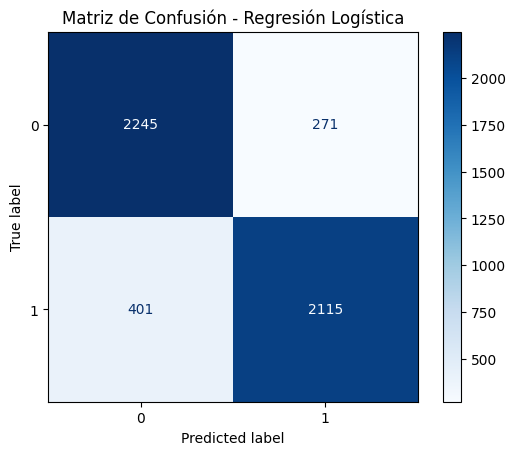

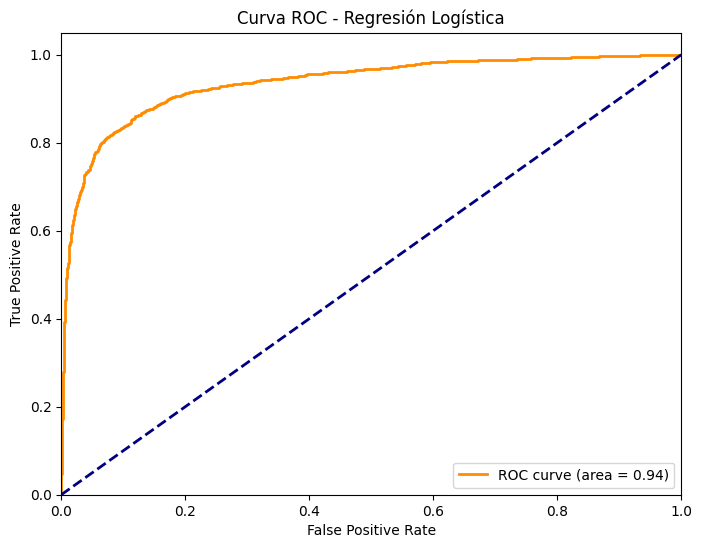

In [ ]:
# Entrenamiento de Modelos con GridSearchCV

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.7, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])
y = (df['overall'] >= 4).astype(int)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

# GridSearchCV para Regresi√≥n Log√≠stica
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced')
param_grid = {
    'C': np.logspace(-3, 3, 7),  # Valores de C para probar
    'penalty': ['l1', 'l2']  # Tipo de regularizaci√≥n
}

log_reg_grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5),  # Validaci√≥n cruzada estratificada
    scoring='f1',  # M√©trica de evaluaci√≥n
    n_jobs=-1,  # Usar todos los n√∫cleos disponibles
    verbose=1  # Mostrar progreso
)

log_reg_grid.fit(X_train, y_train)
print(f"Mejores par√°metros para Regresi√≥n Log√≠stica: {log_reg_grid.best_params_}")

# Evaluaci√≥n del modelo de Regresi√≥n Log√≠stica
y_pred = log_reg_grid.predict(X_test)
y_proba = log_reg_grid.predict_proba(X_test)[:, 1]

print("Reporte de Clasificaci√≥n (Regresi√≥n Log√≠stica):")
print(classification_report(y_test, y_pred))

# Matriz de Confusi√≥n para Regresi√≥n Log√≠stica
ConfusionMatrixDisplay.from_estimator(log_reg_grid, X_test, y_test, cmap='Blues')
plt.title('Matriz de Confusi√≥n - Regresi√≥n Log√≠stica')
plt.show()

# Curva ROC para Regresi√≥n Log√≠stica
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresi√≥n Log√≠stica')
plt.legend(loc="lower right")
plt.show()


# Creaci√≥n de un Dataset Personalizado para BERT

## Componentes

- **texts**: Lista de textos preprocesados.
- **labels**: Lista de etiquetas (0 para negativo, 1 para positivo).
- **tokenizer**: Tokenizador de BERT para convertir texto en tokens.
- **max_len**: Longitud m√°xima de los textos (128 en este caso).

## Funcionalidad

- **`__len__`**: Devuelve el n√∫mero de textos en el dataset.
- **`__getitem__`**: Procesa un texto y su etiqueta, devolviendo un diccionario con:
  - **input_ids**: IDs de los tokens.
  - **attention_mask**: M√°scara de atenci√≥n para ignorar tokens de relleno.
  - **labels**: Etiqueta del texto.

## Carga del Tokenizador y Modelo BERT

**Prop√≥sito:**  
Cargar el tokenizador y el modelo preentrenado de BERT para clasificaci√≥n de texto.

**Detalles:**
- **bert-base-uncased**: Versi√≥n de BERT en ingl√©s sin distinci√≥n entre may√∫sculas y min√∫sculas.
- **num_labels=2**: Se configura para clasificaci√≥n binaria (positivo/negativo).

## Verificaci√≥n de GPU

Verificar si hay una GPU disponible y mover el modelo a la GPU para acelerar el entrenamiento.  
Si hay una GPU, el entrenamiento ser√° mucho m√°s r√°pido.

## Preparaci√≥n del Dataset de Entrenamiento

Se crea un dataset de entrenamiento a partir de los textos preprocesados y sus etiquetas.

**Detalles:**
- `df['clean_text'].tolist()`: Lista de textos preprocesados.
- `y.tolist()`: Lista de etiquetas.
- **max_len=128**: Longitud m√°xima de los textos.

## Configuraci√≥n de los Argumentos de Entrenamiento

Configurar los hiperpar√°metros y opciones para el entrenamiento del modelo.

**Par√°metros Clave:**
- **output_dir='./results'**: Directorio para guardar los resultados del entrenamiento.
- **num_train_epochs=3**: N√∫mero de √©pocas de entrenamiento.
- **per_device_train_batch_size=16**: Tama√±o del lote de entrenamiento por dispositivo.
- **warmup_steps=500**: N√∫mero de pasos para el calentamiento del optimizador.
- **weight_decay=0.01**: Regularizaci√≥n L2 para evitar sobreajuste.
- **logging_dir='./logs'**: Directorio para guardar los logs.
- **logging_steps=10**: Frecuencia de logging durante el entrenamiento.

## Entrenamiento del Modelo

Entrenamos el modelo BERT usando el dataset de entrenamiento y los argumentos configurados.

El entrenamiento se realiza de manera eficiente, aprovechando la GPU si est√° disponible.


In [ ]:
# Uso de BERT para Clasificaci√≥n de Texto

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Verificaci√≥n de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_dataset = ReviewDataset(df['clean_text'].tolist(), y.tolist(), tokenizer, max_len=128)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 11/3510 [00:02<13:48,  4.22it/s]

{'loss': 0.7003, 'grad_norm': 2.7453765869140625, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}


  1%|          | 21/3510 [00:05<13:45,  4.23it/s]

{'loss': 0.6782, 'grad_norm': 3.822699546813965, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}


  1%|          | 30/3510 [00:07<14:17,  4.06it/s]

{'loss': 0.6407, 'grad_norm': 4.711337089538574, 'learning_rate': 3e-06, 'epoch': 0.03}


  1%|          | 40/3510 [00:09<13:50,  4.18it/s]

{'loss': 0.5982, 'grad_norm': 2.353830337524414, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.03}


  1%|‚ñè         | 50/3510 [00:12<14:10,  4.07it/s]

{'loss': 0.6619, 'grad_norm': 3.0979321002960205, 'learning_rate': 5e-06, 'epoch': 0.04}


  2%|‚ñè         | 60/3510 [00:14<14:30,  3.96it/s]

{'loss': 0.6013, 'grad_norm': 2.6299848556518555, 'learning_rate': 6e-06, 'epoch': 0.05}


  2%|‚ñè         | 70/3510 [00:17<15:09,  3.78it/s]

{'loss': 0.6368, 'grad_norm': 4.179619789123535, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.06}


  2%|‚ñè         | 81/3510 [00:20<13:59,  4.08it/s]

{'loss': 0.6092, 'grad_norm': 4.813051700592041, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.07}


  3%|‚ñé         | 90/3510 [00:22<13:50,  4.12it/s]

{'loss': 0.5907, 'grad_norm': 8.373180389404297, 'learning_rate': 9e-06, 'epoch': 0.08}


  3%|‚ñé         | 101/3510 [00:25<13:14,  4.29it/s]

{'loss': 0.572, 'grad_norm': 2.3110556602478027, 'learning_rate': 1e-05, 'epoch': 0.09}


  3%|‚ñé         | 110/3510 [00:27<13:32,  4.18it/s]

{'loss': 0.575, 'grad_norm': 4.230386734008789, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.09}


  3%|‚ñé         | 121/3510 [00:29<13:36,  4.15it/s]

{'loss': 0.599, 'grad_norm': 3.6450324058532715, 'learning_rate': 1.2e-05, 'epoch': 0.1}


  4%|‚ñé         | 130/3510 [00:31<12:51,  4.38it/s]

{'loss': 0.5578, 'grad_norm': 5.558316230773926, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.11}


  4%|‚ñç         | 140/3510 [00:34<13:31,  4.15it/s]

{'loss': 0.4856, 'grad_norm': 4.581233024597168, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.12}


  4%|‚ñç         | 150/3510 [00:36<13:12,  4.24it/s]

{'loss': 0.582, 'grad_norm': 9.198521614074707, 'learning_rate': 1.5e-05, 'epoch': 0.13}


  5%|‚ñç         | 161/3510 [00:39<13:40,  4.08it/s]

{'loss': 0.5141, 'grad_norm': 4.206453800201416, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.14}


  5%|‚ñç         | 170/3510 [00:41<12:57,  4.30it/s]

{'loss': 0.5223, 'grad_norm': 6.265049457550049, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.15}


  5%|‚ñå         | 180/3510 [00:43<13:12,  4.20it/s]

{'loss': 0.5165, 'grad_norm': 3.6774892807006836, 'learning_rate': 1.8e-05, 'epoch': 0.15}


  5%|‚ñå         | 190/3510 [00:46<13:34,  4.07it/s]

{'loss': 0.4862, 'grad_norm': 7.814061641693115, 'learning_rate': 1.9e-05, 'epoch': 0.16}


  6%|‚ñå         | 201/3510 [00:48<13:15,  4.16it/s]

{'loss': 0.4567, 'grad_norm': 12.322182655334473, 'learning_rate': 2e-05, 'epoch': 0.17}


  6%|‚ñå         | 210/3510 [00:51<12:57,  4.25it/s]

{'loss': 0.5303, 'grad_norm': 5.351533889770508, 'learning_rate': 2.1e-05, 'epoch': 0.18}


  6%|‚ñã         | 221/3510 [00:53<13:00,  4.22it/s]

{'loss': 0.4463, 'grad_norm': 7.8557963371276855, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.19}


  7%|‚ñã         | 230/3510 [00:55<13:13,  4.13it/s]

{'loss': 0.5395, 'grad_norm': 12.303977012634277, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.2}


  7%|‚ñã         | 240/3510 [00:58<13:18,  4.10it/s]

{'loss': 0.4178, 'grad_norm': 3.3118131160736084, 'learning_rate': 2.4e-05, 'epoch': 0.21}


  7%|‚ñã         | 250/3510 [01:00<13:10,  4.13it/s]

{'loss': 0.5976, 'grad_norm': 5.067016124725342, 'learning_rate': 2.5e-05, 'epoch': 0.21}


  7%|‚ñã         | 261/3510 [01:03<13:22,  4.05it/s]

{'loss': 0.448, 'grad_norm': 6.6816864013671875, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.22}


  8%|‚ñä         | 271/3510 [01:05<13:00,  4.15it/s]

{'loss': 0.4636, 'grad_norm': 17.71039581298828, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.23}


  8%|‚ñä         | 280/3510 [01:08<12:46,  4.21it/s]

{'loss': 0.4724, 'grad_norm': 5.610719203948975, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.24}


  8%|‚ñä         | 290/3510 [01:10<12:32,  4.28it/s]

{'loss': 0.4702, 'grad_norm': 4.380529403686523, 'learning_rate': 2.9e-05, 'epoch': 0.25}


  9%|‚ñä         | 301/3510 [01:13<12:44,  4.20it/s]

{'loss': 0.4754, 'grad_norm': 8.992400169372559, 'learning_rate': 3e-05, 'epoch': 0.26}


  9%|‚ñâ         | 311/3510 [01:15<12:59,  4.10it/s]

{'loss': 0.5107, 'grad_norm': 5.290012836456299, 'learning_rate': 3.1e-05, 'epoch': 0.26}


  9%|‚ñâ         | 321/3510 [01:17<12:50,  4.14it/s]

{'loss': 0.4699, 'grad_norm': 7.399728775024414, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.27}


  9%|‚ñâ         | 330/3510 [01:20<12:56,  4.10it/s]

{'loss': 0.488, 'grad_norm': 9.633211135864258, 'learning_rate': 3.3e-05, 'epoch': 0.28}


 10%|‚ñâ         | 340/3510 [01:22<12:41,  4.16it/s]

{'loss': 0.4902, 'grad_norm': 2.9860658645629883, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.29}


 10%|‚ñà         | 351/3510 [01:25<12:21,  4.26it/s]

{'loss': 0.3793, 'grad_norm': 6.032176971435547, 'learning_rate': 3.5e-05, 'epoch': 0.3}


 10%|‚ñà         | 360/3510 [01:27<12:32,  4.18it/s]

{'loss': 0.3723, 'grad_norm': 6.142289161682129, 'learning_rate': 3.6e-05, 'epoch': 0.31}


 11%|‚ñà         | 371/3510 [01:30<12:37,  4.14it/s]

{'loss': 0.5488, 'grad_norm': 11.754212379455566, 'learning_rate': 3.7e-05, 'epoch': 0.32}


 11%|‚ñà         | 381/3510 [01:32<12:37,  4.13it/s]

{'loss': 0.4339, 'grad_norm': 9.800512313842773, 'learning_rate': 3.8e-05, 'epoch': 0.32}


 11%|‚ñà         | 391/3510 [01:34<12:31,  4.15it/s]

{'loss': 0.4668, 'grad_norm': 6.85015869140625, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.33}


 11%|‚ñà‚ñè        | 401/3510 [01:37<12:54,  4.02it/s]

{'loss': 0.3887, 'grad_norm': 6.4330010414123535, 'learning_rate': 4e-05, 'epoch': 0.34}


 12%|‚ñà‚ñè        | 411/3510 [01:39<12:41,  4.07it/s]

{'loss': 0.434, 'grad_norm': 11.913899421691895, 'learning_rate': 4.1e-05, 'epoch': 0.35}


 12%|‚ñà‚ñè        | 420/3510 [01:42<12:47,  4.03it/s]

{'loss': 0.4567, 'grad_norm': 9.225374221801758, 'learning_rate': 4.2e-05, 'epoch': 0.36}


 12%|‚ñà‚ñè        | 431/3510 [01:44<12:15,  4.19it/s]

{'loss': 0.3312, 'grad_norm': 6.759793758392334, 'learning_rate': 4.3e-05, 'epoch': 0.37}


 13%|‚ñà‚ñé        | 441/3510 [01:47<12:28,  4.10it/s]

{'loss': 0.4794, 'grad_norm': 9.058150291442871, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.38}


 13%|‚ñà‚ñé        | 451/3510 [01:49<12:53,  3.95it/s]

{'loss': 0.4413, 'grad_norm': 5.083812713623047, 'learning_rate': 4.5e-05, 'epoch': 0.38}


 13%|‚ñà‚ñé        | 461/3510 [01:52<12:32,  4.05it/s]

{'loss': 0.5181, 'grad_norm': 18.803096771240234, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.39}


 13%|‚ñà‚ñé        | 471/3510 [01:54<12:07,  4.18it/s]

{'loss': 0.5325, 'grad_norm': 4.7733635902404785, 'learning_rate': 4.7e-05, 'epoch': 0.4}


 14%|‚ñà‚ñé        | 480/3510 [01:56<12:16,  4.12it/s]

{'loss': 0.3717, 'grad_norm': 9.428232192993164, 'learning_rate': 4.8e-05, 'epoch': 0.41}


 14%|‚ñà‚ñç        | 491/3510 [01:59<12:00,  4.19it/s]

{'loss': 0.4318, 'grad_norm': 7.534194469451904, 'learning_rate': 4.9e-05, 'epoch': 0.42}


 14%|‚ñà‚ñç        | 500/3510 [02:01<11:45,  4.26it/s]

{'loss': 0.4895, 'grad_norm': 15.917460441589355, 'learning_rate': 5e-05, 'epoch': 0.43}


 15%|‚ñà‚ñç        | 511/3510 [02:05<12:26,  4.02it/s]

{'loss': 0.448, 'grad_norm': 7.005894660949707, 'learning_rate': 4.983388704318937e-05, 'epoch': 0.44}


 15%|‚ñà‚ñç        | 521/3510 [02:08<12:00,  4.15it/s]

{'loss': 0.419, 'grad_norm': 7.317008018493652, 'learning_rate': 4.966777408637874e-05, 'epoch': 0.44}


 15%|‚ñà‚ñå        | 530/3510 [02:10<11:57,  4.15it/s]

{'loss': 0.4364, 'grad_norm': 8.70485782623291, 'learning_rate': 4.950166112956811e-05, 'epoch': 0.45}


 15%|‚ñà‚ñå        | 541/3510 [02:13<11:57,  4.14it/s]

{'loss': 0.493, 'grad_norm': 6.7014641761779785, 'learning_rate': 4.933554817275748e-05, 'epoch': 0.46}


 16%|‚ñà‚ñå        | 550/3510 [02:15<11:51,  4.16it/s]

{'loss': 0.4692, 'grad_norm': 3.440701723098755, 'learning_rate': 4.916943521594685e-05, 'epoch': 0.47}


 16%|‚ñà‚ñå        | 560/3510 [02:17<11:52,  4.14it/s]

{'loss': 0.5578, 'grad_norm': 8.151359558105469, 'learning_rate': 4.900332225913621e-05, 'epoch': 0.48}


 16%|‚ñà‚ñå        | 570/3510 [02:20<11:46,  4.16it/s]

{'loss': 0.4627, 'grad_norm': 5.94618558883667, 'learning_rate': 4.883720930232558e-05, 'epoch': 0.49}


 17%|‚ñà‚ñã        | 580/3510 [02:22<11:43,  4.17it/s]

{'loss': 0.4015, 'grad_norm': 11.504228591918945, 'learning_rate': 4.8671096345514956e-05, 'epoch': 0.5}


 17%|‚ñà‚ñã        | 591/3510 [02:25<11:42,  4.16it/s]

{'loss': 0.3975, 'grad_norm': 8.407756805419922, 'learning_rate': 4.8504983388704325e-05, 'epoch': 0.5}


 17%|‚ñà‚ñã        | 600/3510 [02:27<11:49,  4.10it/s]

{'loss': 0.3629, 'grad_norm': 5.367722988128662, 'learning_rate': 4.833887043189369e-05, 'epoch': 0.51}


 17%|‚ñà‚ñã        | 610/3510 [02:29<11:54,  4.06it/s]

{'loss': 0.4641, 'grad_norm': 4.953908443450928, 'learning_rate': 4.8172757475083056e-05, 'epoch': 0.52}


 18%|‚ñà‚ñä        | 621/3510 [02:32<11:27,  4.20it/s]

{'loss': 0.4748, 'grad_norm': 8.903955459594727, 'learning_rate': 4.8006644518272426e-05, 'epoch': 0.53}


 18%|‚ñà‚ñä        | 631/3510 [02:34<11:38,  4.12it/s]

{'loss': 0.3608, 'grad_norm': 4.154150009155273, 'learning_rate': 4.78405315614618e-05, 'epoch': 0.54}


 18%|‚ñà‚ñä        | 640/3510 [02:37<11:35,  4.13it/s]

{'loss': 0.4416, 'grad_norm': 5.568104267120361, 'learning_rate': 4.7674418604651164e-05, 'epoch': 0.55}


 19%|‚ñà‚ñä        | 651/3510 [02:39<11:09,  4.27it/s]

{'loss': 0.4177, 'grad_norm': 5.937244892120361, 'learning_rate': 4.750830564784053e-05, 'epoch': 0.56}


 19%|‚ñà‚ñâ        | 661/3510 [02:42<11:37,  4.09it/s]

{'loss': 0.4779, 'grad_norm': 10.017723083496094, 'learning_rate': 4.73421926910299e-05, 'epoch': 0.56}


 19%|‚ñà‚ñâ        | 671/3510 [02:44<11:19,  4.18it/s]

{'loss': 0.5593, 'grad_norm': 2.965425968170166, 'learning_rate': 4.717607973421927e-05, 'epoch': 0.57}


 19%|‚ñà‚ñâ        | 681/3510 [02:46<11:01,  4.27it/s]

{'loss': 0.4708, 'grad_norm': 3.0165176391601562, 'learning_rate': 4.700996677740864e-05, 'epoch': 0.58}


 20%|‚ñà‚ñâ        | 691/3510 [02:49<11:05,  4.24it/s]

{'loss': 0.4406, 'grad_norm': 5.4951934814453125, 'learning_rate': 4.684385382059801e-05, 'epoch': 0.59}


 20%|‚ñà‚ñâ        | 700/3510 [02:51<11:09,  4.20it/s]

{'loss': 0.356, 'grad_norm': 5.785931587219238, 'learning_rate': 4.667774086378738e-05, 'epoch': 0.6}


 20%|‚ñà‚ñà        | 711/3510 [02:53<11:11,  4.17it/s]

{'loss': 0.4388, 'grad_norm': 6.220391750335693, 'learning_rate': 4.651162790697675e-05, 'epoch': 0.61}


 21%|‚ñà‚ñà        | 720/3510 [02:56<11:16,  4.13it/s]

{'loss': 0.5072, 'grad_norm': 2.892117977142334, 'learning_rate': 4.634551495016611e-05, 'epoch': 0.62}


 21%|‚ñà‚ñà        | 730/3510 [02:58<11:15,  4.12it/s]

{'loss': 0.391, 'grad_norm': 5.204306602478027, 'learning_rate': 4.6179401993355486e-05, 'epoch': 0.62}


 21%|‚ñà‚ñà        | 740/3510 [03:00<11:10,  4.13it/s]

{'loss': 0.4748, 'grad_norm': 4.958937644958496, 'learning_rate': 4.6013289036544856e-05, 'epoch': 0.63}


 21%|‚ñà‚ñà‚ñè       | 750/3510 [03:03<10:55,  4.21it/s]

{'loss': 0.3422, 'grad_norm': 4.665211200714111, 'learning_rate': 4.5847176079734225e-05, 'epoch': 0.64}


 22%|‚ñà‚ñà‚ñè       | 760/3510 [03:05<11:02,  4.15it/s]

{'loss': 0.3003, 'grad_norm': 18.443578720092773, 'learning_rate': 4.568106312292359e-05, 'epoch': 0.65}


 22%|‚ñà‚ñà‚ñè       | 771/3510 [03:08<10:49,  4.21it/s]

{'loss': 0.4262, 'grad_norm': 11.518183708190918, 'learning_rate': 4.5514950166112956e-05, 'epoch': 0.66}


 22%|‚ñà‚ñà‚ñè       | 781/3510 [03:10<10:58,  4.14it/s]

{'loss': 0.5123, 'grad_norm': 9.478103637695312, 'learning_rate': 4.5348837209302326e-05, 'epoch': 0.67}


 23%|‚ñà‚ñà‚ñé       | 791/3510 [03:13<10:40,  4.25it/s]

{'loss': 0.4901, 'grad_norm': 8.344677925109863, 'learning_rate': 4.51827242524917e-05, 'epoch': 0.68}


 23%|‚ñà‚ñà‚ñé       | 801/3510 [03:15<10:39,  4.24it/s]

{'loss': 0.4809, 'grad_norm': 7.638911724090576, 'learning_rate': 4.5016611295681064e-05, 'epoch': 0.68}


 23%|‚ñà‚ñà‚ñé       | 810/3510 [03:17<10:26,  4.31it/s]

{'loss': 0.4639, 'grad_norm': 12.572127342224121, 'learning_rate': 4.485049833887043e-05, 'epoch': 0.69}


 23%|‚ñà‚ñà‚ñé       | 820/3510 [03:19<10:21,  4.33it/s]

{'loss': 0.5698, 'grad_norm': 5.331135272979736, 'learning_rate': 4.46843853820598e-05, 'epoch': 0.7}


 24%|‚ñà‚ñà‚ñé       | 830/3510 [03:22<11:04,  4.03it/s]

{'loss': 0.4607, 'grad_norm': 12.381708145141602, 'learning_rate': 4.451827242524917e-05, 'epoch': 0.71}


 24%|‚ñà‚ñà‚ñç       | 841/3510 [03:25<11:01,  4.03it/s]

{'loss': 0.5205, 'grad_norm': 5.158529758453369, 'learning_rate': 4.435215946843854e-05, 'epoch': 0.72}


 24%|‚ñà‚ñà‚ñç       | 851/3510 [03:27<10:47,  4.11it/s]

{'loss': 0.412, 'grad_norm': 3.1291327476501465, 'learning_rate': 4.418604651162791e-05, 'epoch': 0.73}


 25%|‚ñà‚ñà‚ñç       | 861/3510 [03:29<10:41,  4.13it/s]

{'loss': 0.3907, 'grad_norm': 3.925845146179199, 'learning_rate': 4.401993355481728e-05, 'epoch': 0.74}


 25%|‚ñà‚ñà‚ñç       | 871/3510 [03:32<10:51,  4.05it/s]

{'loss': 0.4287, 'grad_norm': 4.985764503479004, 'learning_rate': 4.385382059800665e-05, 'epoch': 0.74}


 25%|‚ñà‚ñà‚ñå       | 880/3510 [03:34<10:34,  4.15it/s]

{'loss': 0.4064, 'grad_norm': 6.927889347076416, 'learning_rate': 4.368770764119601e-05, 'epoch': 0.75}


 25%|‚ñà‚ñà‚ñå       | 891/3510 [03:37<10:55,  3.99it/s]

{'loss': 0.3676, 'grad_norm': 7.616134166717529, 'learning_rate': 4.3521594684385386e-05, 'epoch': 0.76}


 26%|‚ñà‚ñà‚ñå       | 901/3510 [03:39<10:24,  4.18it/s]

{'loss': 0.4258, 'grad_norm': 3.9223482608795166, 'learning_rate': 4.3355481727574756e-05, 'epoch': 0.77}


 26%|‚ñà‚ñà‚ñå       | 910/3510 [03:41<10:31,  4.12it/s]

{'loss': 0.4807, 'grad_norm': 4.4106125831604, 'learning_rate': 4.3189368770764125e-05, 'epoch': 0.78}


 26%|‚ñà‚ñà‚ñå       | 921/3510 [03:44<10:30,  4.10it/s]

{'loss': 0.4422, 'grad_norm': 7.606504440307617, 'learning_rate': 4.302325581395349e-05, 'epoch': 0.79}


 26%|‚ñà‚ñà‚ñã       | 930/3510 [03:46<10:27,  4.11it/s]

{'loss': 0.4253, 'grad_norm': 7.933626651763916, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.79}


 27%|‚ñà‚ñà‚ñã       | 940/3510 [03:49<10:53,  3.93it/s]

{'loss': 0.4114, 'grad_norm': 7.8603057861328125, 'learning_rate': 4.269102990033223e-05, 'epoch': 0.8}


 27%|‚ñà‚ñà‚ñã       | 951/3510 [03:52<10:21,  4.12it/s]

{'loss': 0.3607, 'grad_norm': 11.6827392578125, 'learning_rate': 4.2524916943521595e-05, 'epoch': 0.81}


 27%|‚ñà‚ñà‚ñã       | 960/3510 [03:54<10:21,  4.10it/s]

{'loss': 0.5184, 'grad_norm': 6.224063396453857, 'learning_rate': 4.2358803986710964e-05, 'epoch': 0.82}


 28%|‚ñà‚ñà‚ñä       | 970/3510 [03:56<10:01,  4.23it/s]

{'loss': 0.3863, 'grad_norm': 5.397536754608154, 'learning_rate': 4.219269102990033e-05, 'epoch': 0.83}


 28%|‚ñà‚ñà‚ñä       | 981/3510 [03:59<10:20,  4.08it/s]

{'loss': 0.4232, 'grad_norm': 5.08372163772583, 'learning_rate': 4.20265780730897e-05, 'epoch': 0.84}


 28%|‚ñà‚ñà‚ñä       | 991/3510 [04:01<10:15,  4.09it/s]

{'loss': 0.4258, 'grad_norm': 5.408901214599609, 'learning_rate': 4.186046511627907e-05, 'epoch': 0.85}


 28%|‚ñà‚ñà‚ñä       | 1000/3510 [04:04<10:31,  3.97it/s]

{'loss': 0.4587, 'grad_norm': 8.666818618774414, 'learning_rate': 4.169435215946844e-05, 'epoch': 0.85}


 29%|‚ñà‚ñà‚ñâ       | 1010/3510 [04:07<11:08,  3.74it/s]

{'loss': 0.354, 'grad_norm': 4.032800674438477, 'learning_rate': 4.152823920265781e-05, 'epoch': 0.86}


 29%|‚ñà‚ñà‚ñâ       | 1021/3510 [04:10<09:56,  4.17it/s]

{'loss': 0.3635, 'grad_norm': 7.658715724945068, 'learning_rate': 4.136212624584718e-05, 'epoch': 0.87}


 29%|‚ñà‚ñà‚ñâ       | 1031/3510 [04:12<09:49,  4.21it/s]

{'loss': 0.4213, 'grad_norm': 10.847405433654785, 'learning_rate': 4.119601328903655e-05, 'epoch': 0.88}


 30%|‚ñà‚ñà‚ñâ       | 1040/3510 [04:15<09:39,  4.26it/s]

{'loss': 0.3876, 'grad_norm': 7.734187602996826, 'learning_rate': 4.102990033222592e-05, 'epoch': 0.89}


 30%|‚ñà‚ñà‚ñâ       | 1051/3510 [04:17<09:43,  4.21it/s]

{'loss': 0.4011, 'grad_norm': 2.9359474182128906, 'learning_rate': 4.0863787375415286e-05, 'epoch': 0.9}


 30%|‚ñà‚ñà‚ñà       | 1061/3510 [04:20<09:50,  4.15it/s]

{'loss': 0.513, 'grad_norm': 3.6547844409942627, 'learning_rate': 4.0697674418604655e-05, 'epoch': 0.91}


 31%|‚ñà‚ñà‚ñà       | 1071/3510 [04:22<09:24,  4.32it/s]

{'loss': 0.4188, 'grad_norm': 4.404245376586914, 'learning_rate': 4.053156146179402e-05, 'epoch': 0.91}


 31%|‚ñà‚ñà‚ñà       | 1080/3510 [04:24<09:39,  4.19it/s]

{'loss': 0.4306, 'grad_norm': 5.114594459533691, 'learning_rate': 4.036544850498339e-05, 'epoch': 0.92}


 31%|‚ñà‚ñà‚ñà       | 1091/3510 [04:27<09:45,  4.13it/s]

{'loss': 0.3701, 'grad_norm': 8.743830680847168, 'learning_rate': 4.019933554817276e-05, 'epoch': 0.93}


 31%|‚ñà‚ñà‚ñà‚ñè      | 1100/3510 [04:29<09:51,  4.07it/s]

{'loss': 0.3026, 'grad_norm': 10.433226585388184, 'learning_rate': 4.003322259136213e-05, 'epoch': 0.94}


 32%|‚ñà‚ñà‚ñà‚ñè      | 1111/3510 [04:32<09:50,  4.06it/s]

{'loss': 0.4933, 'grad_norm': 7.9209442138671875, 'learning_rate': 3.9867109634551495e-05, 'epoch': 0.95}


 32%|‚ñà‚ñà‚ñà‚ñè      | 1120/3510 [04:34<09:36,  4.15it/s]

{'loss': 0.5033, 'grad_norm': 7.402910232543945, 'learning_rate': 3.9700996677740864e-05, 'epoch': 0.96}


 32%|‚ñà‚ñà‚ñà‚ñè      | 1130/3510 [04:36<09:38,  4.11it/s]

{'loss': 0.4753, 'grad_norm': 8.840415954589844, 'learning_rate': 3.953488372093023e-05, 'epoch': 0.97}


 32%|‚ñà‚ñà‚ñà‚ñè      | 1140/3510 [04:39<09:56,  3.97it/s]

{'loss': 0.4038, 'grad_norm': 6.725221633911133, 'learning_rate': 3.936877076411961e-05, 'epoch': 0.97}


 33%|‚ñà‚ñà‚ñà‚ñé      | 1150/3510 [04:41<09:36,  4.10it/s]

{'loss': 0.3961, 'grad_norm': 8.316668510437012, 'learning_rate': 3.920265780730897e-05, 'epoch': 0.98}


 33%|‚ñà‚ñà‚ñà‚ñé      | 1161/3510 [04:44<09:24,  4.16it/s]

{'loss': 0.4499, 'grad_norm': 5.585962772369385, 'learning_rate': 3.903654485049834e-05, 'epoch': 0.99}


 33%|‚ñà‚ñà‚ñà‚ñé      | 1170/3510 [04:46<09:09,  4.26it/s]

{'loss': 0.3402, 'grad_norm': 41.66870880126953, 'learning_rate': 3.887043189368771e-05, 'epoch': 1.0}


 34%|‚ñà‚ñà‚ñà‚ñé      | 1180/3510 [04:48<09:21,  4.15it/s]

{'loss': 0.2624, 'grad_norm': 4.068447589874268, 'learning_rate': 3.870431893687708e-05, 'epoch': 1.01}


 34%|‚ñà‚ñà‚ñà‚ñç      | 1190/3510 [04:51<09:39,  4.01it/s]

{'loss': 0.3355, 'grad_norm': 15.550260543823242, 'learning_rate': 3.853820598006645e-05, 'epoch': 1.02}


 34%|‚ñà‚ñà‚ñà‚ñç      | 1201/3510 [04:54<09:23,  4.10it/s]

{'loss': 0.2387, 'grad_norm': 2.236382484436035, 'learning_rate': 3.837209302325582e-05, 'epoch': 1.03}


 35%|‚ñà‚ñà‚ñà‚ñç      | 1211/3510 [04:56<09:26,  4.06it/s]

{'loss': 0.3908, 'grad_norm': 7.452634811401367, 'learning_rate': 3.8205980066445186e-05, 'epoch': 1.03}


 35%|‚ñà‚ñà‚ñà‚ñç      | 1221/3510 [04:58<09:04,  4.21it/s]

{'loss': 0.3565, 'grad_norm': 3.5850741863250732, 'learning_rate': 3.8039867109634555e-05, 'epoch': 1.04}


 35%|‚ñà‚ñà‚ñà‚ñå      | 1230/3510 [05:01<09:35,  3.96it/s]

{'loss': 0.2979, 'grad_norm': 6.840407371520996, 'learning_rate': 3.787375415282392e-05, 'epoch': 1.05}


 35%|‚ñà‚ñà‚ñà‚ñå      | 1241/3510 [05:03<09:09,  4.13it/s]

{'loss': 0.3695, 'grad_norm': 11.536824226379395, 'learning_rate': 3.7707641196013294e-05, 'epoch': 1.06}


 36%|‚ñà‚ñà‚ñà‚ñå      | 1250/3510 [05:05<09:19,  4.04it/s]

{'loss': 0.3575, 'grad_norm': 6.346646308898926, 'learning_rate': 3.754152823920266e-05, 'epoch': 1.07}


 36%|‚ñà‚ñà‚ñà‚ñå      | 1261/3510 [05:08<09:14,  4.06it/s]

{'loss': 0.2795, 'grad_norm': 4.887731552124023, 'learning_rate': 3.737541528239203e-05, 'epoch': 1.08}


 36%|‚ñà‚ñà‚ñà‚ñå      | 1271/3510 [05:11<09:02,  4.12it/s]

{'loss': 0.3246, 'grad_norm': 10.890159606933594, 'learning_rate': 3.7209302325581394e-05, 'epoch': 1.09}


 36%|‚ñà‚ñà‚ñà‚ñã      | 1280/3510 [05:13<09:06,  4.08it/s]

{'loss': 0.3768, 'grad_norm': 8.582012176513672, 'learning_rate': 3.7043189368770764e-05, 'epoch': 1.09}


 37%|‚ñà‚ñà‚ñà‚ñã      | 1291/3510 [05:15<08:56,  4.14it/s]

{'loss': 0.2475, 'grad_norm': 21.464679718017578, 'learning_rate': 3.687707641196013e-05, 'epoch': 1.1}


 37%|‚ñà‚ñà‚ñà‚ñã      | 1300/3510 [05:18<08:56,  4.12it/s]

{'loss': 0.3246, 'grad_norm': 13.642265319824219, 'learning_rate': 3.67109634551495e-05, 'epoch': 1.11}


 37%|‚ñà‚ñà‚ñà‚ñã      | 1311/3510 [05:20<08:44,  4.19it/s]

{'loss': 0.4259, 'grad_norm': 8.670388221740723, 'learning_rate': 3.654485049833887e-05, 'epoch': 1.12}


 38%|‚ñà‚ñà‚ñà‚ñä      | 1321/3510 [05:23<08:33,  4.26it/s]

{'loss': 0.2783, 'grad_norm': 3.766453981399536, 'learning_rate': 3.637873754152824e-05, 'epoch': 1.13}


 38%|‚ñà‚ñà‚ñà‚ñä      | 1331/3510 [05:25<08:36,  4.22it/s]

{'loss': 0.4385, 'grad_norm': 10.585755348205566, 'learning_rate': 3.621262458471761e-05, 'epoch': 1.14}


 38%|‚ñà‚ñà‚ñà‚ñä      | 1340/3510 [05:27<08:46,  4.12it/s]

{'loss': 0.3717, 'grad_norm': 10.4650297164917, 'learning_rate': 3.604651162790698e-05, 'epoch': 1.15}


 38%|‚ñà‚ñà‚ñà‚ñä      | 1351/3510 [05:30<08:26,  4.26it/s]

{'loss': 0.3101, 'grad_norm': 3.379417896270752, 'learning_rate': 3.588039867109635e-05, 'epoch': 1.15}


 39%|‚ñà‚ñà‚ñà‚ñä      | 1360/3510 [05:32<08:40,  4.13it/s]

{'loss': 0.3589, 'grad_norm': 10.132628440856934, 'learning_rate': 3.571428571428572e-05, 'epoch': 1.16}


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1370/3510 [05:34<08:37,  4.14it/s]

{'loss': 0.2629, 'grad_norm': 3.429211378097534, 'learning_rate': 3.5548172757475086e-05, 'epoch': 1.17}


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1380/3510 [05:37<08:31,  4.16it/s]

{'loss': 0.302, 'grad_norm': 6.342537879943848, 'learning_rate': 3.5382059800664455e-05, 'epoch': 1.18}


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1391/3510 [05:39<08:15,  4.28it/s]

{'loss': 0.2975, 'grad_norm': 14.399483680725098, 'learning_rate': 3.521594684385382e-05, 'epoch': 1.19}


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1401/3510 [05:42<08:25,  4.17it/s]

{'loss': 0.3104, 'grad_norm': 4.709582805633545, 'learning_rate': 3.5049833887043194e-05, 'epoch': 1.2}


 40%|‚ñà‚ñà‚ñà‚ñà      | 1411/3510 [05:44<08:15,  4.24it/s]

{'loss': 0.3105, 'grad_norm': 10.113263130187988, 'learning_rate': 3.488372093023256e-05, 'epoch': 1.21}


 40%|‚ñà‚ñà‚ñà‚ñà      | 1421/3510 [05:47<08:15,  4.22it/s]

{'loss': 0.3692, 'grad_norm': 11.800650596618652, 'learning_rate': 3.4717607973421925e-05, 'epoch': 1.21}


 41%|‚ñà‚ñà‚ñà‚ñà      | 1431/3510 [05:49<08:19,  4.16it/s]

{'loss': 0.3836, 'grad_norm': 4.07858419418335, 'learning_rate': 3.4551495016611294e-05, 'epoch': 1.22}


 41%|‚ñà‚ñà‚ñà‚ñà      | 1440/3510 [05:51<08:14,  4.19it/s]

{'loss': 0.2803, 'grad_norm': 13.342194557189941, 'learning_rate': 3.4385382059800664e-05, 'epoch': 1.23}


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1450/3510 [05:53<07:56,  4.32it/s]

{'loss': 0.4502, 'grad_norm': 4.084381103515625, 'learning_rate': 3.421926910299004e-05, 'epoch': 1.24}


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1461/3510 [05:56<08:15,  4.14it/s]

{'loss': 0.3119, 'grad_norm': 10.025935173034668, 'learning_rate': 3.40531561461794e-05, 'epoch': 1.25}


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1471/3510 [05:59<08:21,  4.07it/s]

{'loss': 0.2929, 'grad_norm': 15.958105087280273, 'learning_rate': 3.388704318936877e-05, 'epoch': 1.26}


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1480/3510 [06:01<07:55,  4.27it/s]

{'loss': 0.2426, 'grad_norm': 7.569163799285889, 'learning_rate': 3.372093023255814e-05, 'epoch': 1.26}


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1491/3510 [06:03<08:18,  4.05it/s]

{'loss': 0.3614, 'grad_norm': 8.213348388671875, 'learning_rate': 3.355481727574751e-05, 'epoch': 1.27}


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1500/3510 [06:06<08:29,  3.94it/s]

{'loss': 0.2367, 'grad_norm': 11.728532791137695, 'learning_rate': 3.338870431893688e-05, 'epoch': 1.28}


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1510/3510 [06:09<08:23,  3.97it/s]

{'loss': 0.4156, 'grad_norm': 16.961896896362305, 'learning_rate': 3.322259136212625e-05, 'epoch': 1.29}


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1521/3510 [06:12<07:46,  4.26it/s]

{'loss': 0.2334, 'grad_norm': 2.9376397132873535, 'learning_rate': 3.305647840531562e-05, 'epoch': 1.3}


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1531/3510 [06:14<07:58,  4.13it/s]

{'loss': 0.3035, 'grad_norm': 15.903950691223145, 'learning_rate': 3.2890365448504986e-05, 'epoch': 1.31}


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1541/3510 [06:17<08:11,  4.01it/s]

{'loss': 0.2758, 'grad_norm': 15.348445892333984, 'learning_rate': 3.272425249169435e-05, 'epoch': 1.32}


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1550/3510 [06:19<08:06,  4.03it/s]

{'loss': 0.2907, 'grad_norm': 7.778436660766602, 'learning_rate': 3.2558139534883724e-05, 'epoch': 1.32}


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1560/3510 [06:22<08:41,  3.74it/s]

{'loss': 0.242, 'grad_norm': 7.060824871063232, 'learning_rate': 3.2392026578073094e-05, 'epoch': 1.33}


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1571/3510 [06:25<07:52,  4.10it/s]

{'loss': 0.2596, 'grad_norm': 8.513545989990234, 'learning_rate': 3.222591362126246e-05, 'epoch': 1.34}


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1580/3510 [06:27<07:38,  4.21it/s]

{'loss': 0.3403, 'grad_norm': 8.368915557861328, 'learning_rate': 3.2059800664451825e-05, 'epoch': 1.35}


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1591/3510 [06:29<07:37,  4.19it/s]

{'loss': 0.3206, 'grad_norm': 6.236220836639404, 'learning_rate': 3.1893687707641194e-05, 'epoch': 1.36}


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1601/3510 [06:32<07:42,  4.12it/s]

{'loss': 0.3244, 'grad_norm': 6.617138385772705, 'learning_rate': 3.172757475083057e-05, 'epoch': 1.37}


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1610/3510 [06:34<07:29,  4.23it/s]

{'loss': 0.3052, 'grad_norm': 6.756004810333252, 'learning_rate': 3.156146179401994e-05, 'epoch': 1.38}


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1621/3510 [06:36<07:36,  4.14it/s]

{'loss': 0.3012, 'grad_norm': 5.381088733673096, 'learning_rate': 3.13953488372093e-05, 'epoch': 1.38}


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1631/3510 [06:39<07:36,  4.11it/s]

{'loss': 0.2681, 'grad_norm': 9.102551460266113, 'learning_rate': 3.122923588039867e-05, 'epoch': 1.39}


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1640/3510 [06:41<07:29,  4.16it/s]

{'loss': 0.2154, 'grad_norm': 13.122923851013184, 'learning_rate': 3.106312292358804e-05, 'epoch': 1.4}


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1651/3510 [06:44<07:22,  4.20it/s]

{'loss': 0.249, 'grad_norm': 3.9178714752197266, 'learning_rate': 3.089700996677741e-05, 'epoch': 1.41}


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1661/3510 [06:46<07:19,  4.20it/s]

{'loss': 0.2703, 'grad_norm': 4.846124649047852, 'learning_rate': 3.073089700996678e-05, 'epoch': 1.42}


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1670/3510 [06:48<07:00,  4.37it/s]

{'loss': 0.2351, 'grad_norm': 15.286709785461426, 'learning_rate': 3.056478405315615e-05, 'epoch': 1.43}


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1681/3510 [06:51<07:30,  4.06it/s]

{'loss': 0.2393, 'grad_norm': 8.22695255279541, 'learning_rate': 3.0398671096345517e-05, 'epoch': 1.44}


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1691/3510 [06:53<07:18,  4.15it/s]

{'loss': 0.4072, 'grad_norm': 10.533357620239258, 'learning_rate': 3.0232558139534883e-05, 'epoch': 1.44}


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1701/3510 [06:56<07:17,  4.14it/s]

{'loss': 0.1997, 'grad_norm': 5.734280109405518, 'learning_rate': 3.0066445182724255e-05, 'epoch': 1.45}


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1710/3510 [06:58<07:14,  4.15it/s]

{'loss': 0.2462, 'grad_norm': 4.002598285675049, 'learning_rate': 2.9900332225913624e-05, 'epoch': 1.46}


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1721/3510 [07:01<07:08,  4.17it/s]

{'loss': 0.4202, 'grad_norm': 23.20597267150879, 'learning_rate': 2.9734219269102993e-05, 'epoch': 1.47}


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1731/3510 [07:03<07:16,  4.07it/s]

{'loss': 0.2464, 'grad_norm': 4.733734607696533, 'learning_rate': 2.956810631229236e-05, 'epoch': 1.48}


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1741/3510 [07:05<07:03,  4.17it/s]

{'loss': 0.3322, 'grad_norm': 8.159152030944824, 'learning_rate': 2.940199335548173e-05, 'epoch': 1.49}


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1750/3510 [07:08<07:20,  3.99it/s]

{'loss': 0.2076, 'grad_norm': 7.183696269989014, 'learning_rate': 2.92358803986711e-05, 'epoch': 1.5}


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 1760/3510 [07:10<07:10,  4.07it/s]

{'loss': 0.4146, 'grad_norm': 5.411696910858154, 'learning_rate': 2.9069767441860467e-05, 'epoch': 1.5}


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 1770/3510 [07:12<07:14,  4.01it/s]

{'loss': 0.2813, 'grad_norm': 6.0056962966918945, 'learning_rate': 2.8903654485049836e-05, 'epoch': 1.51}


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 1780/3510 [07:15<06:49,  4.23it/s]

{'loss': 0.2479, 'grad_norm': 7.025698184967041, 'learning_rate': 2.8737541528239205e-05, 'epoch': 1.52}


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 1791/3510 [07:17<06:53,  4.15it/s]

{'loss': 0.2661, 'grad_norm': 10.03699016571045, 'learning_rate': 2.857142857142857e-05, 'epoch': 1.53}


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 1801/3510 [07:20<06:51,  4.15it/s]

{'loss': 0.2686, 'grad_norm': 21.644710540771484, 'learning_rate': 2.840531561461794e-05, 'epoch': 1.54}


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 1811/3510 [07:22<06:39,  4.25it/s]

{'loss': 0.2794, 'grad_norm': 2.9294276237487793, 'learning_rate': 2.8239202657807313e-05, 'epoch': 1.55}


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 1821/3510 [07:25<06:32,  4.30it/s]

{'loss': 0.195, 'grad_norm': 10.697993278503418, 'learning_rate': 2.807308970099668e-05, 'epoch': 1.56}


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 1831/3510 [07:27<06:37,  4.22it/s]

{'loss': 0.4813, 'grad_norm': 7.540611743927002, 'learning_rate': 2.7906976744186048e-05, 'epoch': 1.56}


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 1841/3510 [07:29<06:49,  4.07it/s]

{'loss': 0.3088, 'grad_norm': 4.031380653381348, 'learning_rate': 2.7740863787375417e-05, 'epoch': 1.57}


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 1850/3510 [07:32<06:36,  4.19it/s]

{'loss': 0.3448, 'grad_norm': 7.411712169647217, 'learning_rate': 2.7574750830564782e-05, 'epoch': 1.58}


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 1860/3510 [07:34<06:28,  4.25it/s]

{'loss': 0.31, 'grad_norm': 5.047745704650879, 'learning_rate': 2.7408637873754155e-05, 'epoch': 1.59}


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 1871/3510 [07:36<06:31,  4.19it/s]

{'loss': 0.238, 'grad_norm': 7.897420883178711, 'learning_rate': 2.7242524916943524e-05, 'epoch': 1.6}


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 1880/3510 [07:39<06:27,  4.21it/s]

{'loss': 0.3732, 'grad_norm': 9.38647747039795, 'learning_rate': 2.707641196013289e-05, 'epoch': 1.61}


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 1891/3510 [07:41<06:36,  4.08it/s]

{'loss': 0.3647, 'grad_norm': 13.037870407104492, 'learning_rate': 2.691029900332226e-05, 'epoch': 1.62}


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 1901/3510 [07:44<06:25,  4.18it/s]

{'loss': 0.2795, 'grad_norm': 8.423240661621094, 'learning_rate': 2.674418604651163e-05, 'epoch': 1.62}


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 1911/3510 [07:46<06:44,  3.96it/s]

{'loss': 0.3241, 'grad_norm': 14.640236854553223, 'learning_rate': 2.6578073089701e-05, 'epoch': 1.63}


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 1920/3510 [07:48<06:09,  4.30it/s]

{'loss': 0.317, 'grad_norm': 4.708738803863525, 'learning_rate': 2.6411960132890367e-05, 'epoch': 1.64}


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 1930/3510 [07:51<06:30,  4.05it/s]

{'loss': 0.2837, 'grad_norm': 12.376940727233887, 'learning_rate': 2.6245847176079736e-05, 'epoch': 1.65}


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 1941/3510 [07:53<06:19,  4.13it/s]

{'loss': 0.2922, 'grad_norm': 5.858570098876953, 'learning_rate': 2.60797342192691e-05, 'epoch': 1.66}


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 1950/3510 [07:56<06:02,  4.30it/s]

{'loss': 0.2798, 'grad_norm': 13.04979419708252, 'learning_rate': 2.591362126245847e-05, 'epoch': 1.67}


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 1961/3510 [07:58<06:09,  4.19it/s]

{'loss': 0.282, 'grad_norm': 19.37187957763672, 'learning_rate': 2.5747508305647843e-05, 'epoch': 1.68}


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 1971/3510 [08:01<06:01,  4.25it/s]

{'loss': 0.2878, 'grad_norm': 30.4300537109375, 'learning_rate': 2.5581395348837212e-05, 'epoch': 1.68}


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 1980/3510 [08:03<06:03,  4.21it/s]

{'loss': 0.3519, 'grad_norm': 4.306820869445801, 'learning_rate': 2.5415282392026578e-05, 'epoch': 1.69}


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 1990/3510 [08:05<05:54,  4.29it/s]

{'loss': 0.3159, 'grad_norm': 6.252395153045654, 'learning_rate': 2.5249169435215947e-05, 'epoch': 1.7}


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2000/3510 [08:08<06:14,  4.03it/s]

{'loss': 0.3114, 'grad_norm': 5.299747467041016, 'learning_rate': 2.5083056478405313e-05, 'epoch': 1.71}


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2010/3510 [08:11<06:26,  3.89it/s]

{'loss': 0.2809, 'grad_norm': 4.371983528137207, 'learning_rate': 2.4916943521594686e-05, 'epoch': 1.72}


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2020/3510 [08:13<06:01,  4.12it/s]

{'loss': 0.2532, 'grad_norm': 5.954730033874512, 'learning_rate': 2.4750830564784055e-05, 'epoch': 1.73}


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2031/3510 [08:16<05:58,  4.12it/s]

{'loss': 0.2346, 'grad_norm': 4.6524882316589355, 'learning_rate': 2.4584717607973424e-05, 'epoch': 1.74}


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2041/3510 [08:18<05:42,  4.29it/s]

{'loss': 0.4708, 'grad_norm': 9.449419021606445, 'learning_rate': 2.441860465116279e-05, 'epoch': 1.74}


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2050/3510 [08:21<06:02,  4.03it/s]

{'loss': 0.2752, 'grad_norm': 5.284440040588379, 'learning_rate': 2.4252491694352162e-05, 'epoch': 1.75}


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2061/3510 [08:23<05:45,  4.20it/s]

{'loss': 0.3667, 'grad_norm': 6.7224907875061035, 'learning_rate': 2.4086378737541528e-05, 'epoch': 1.76}


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2070/3510 [08:26<05:57,  4.03it/s]

{'loss': 0.2936, 'grad_norm': 9.686349868774414, 'learning_rate': 2.39202657807309e-05, 'epoch': 1.77}


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2081/3510 [08:28<05:44,  4.15it/s]

{'loss': 0.333, 'grad_norm': 2.883690595626831, 'learning_rate': 2.3754152823920267e-05, 'epoch': 1.78}


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2091/3510 [08:31<05:46,  4.09it/s]

{'loss': 0.308, 'grad_norm': 5.609004020690918, 'learning_rate': 2.3588039867109636e-05, 'epoch': 1.79}


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2101/3510 [08:33<05:27,  4.30it/s]

{'loss': 0.2938, 'grad_norm': 8.847113609313965, 'learning_rate': 2.3421926910299005e-05, 'epoch': 1.79}


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2111/3510 [08:35<05:36,  4.16it/s]

{'loss': 0.3036, 'grad_norm': 3.1579065322875977, 'learning_rate': 2.3255813953488374e-05, 'epoch': 1.8}


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2120/3510 [08:38<05:40,  4.08it/s]

{'loss': 0.2173, 'grad_norm': 5.063201427459717, 'learning_rate': 2.3089700996677743e-05, 'epoch': 1.81}


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2130/3510 [08:40<05:48,  3.96it/s]

{'loss': 0.3324, 'grad_norm': 12.193376541137695, 'learning_rate': 2.2923588039867112e-05, 'epoch': 1.82}


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2140/3510 [08:43<05:41,  4.02it/s]

{'loss': 0.3582, 'grad_norm': 11.377191543579102, 'learning_rate': 2.2757475083056478e-05, 'epoch': 1.83}


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2151/3510 [08:45<05:27,  4.15it/s]

{'loss': 0.2421, 'grad_norm': 8.2239990234375, 'learning_rate': 2.259136212624585e-05, 'epoch': 1.84}


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2160/3510 [08:48<05:29,  4.10it/s]

{'loss': 0.2322, 'grad_norm': 5.619138240814209, 'learning_rate': 2.2425249169435217e-05, 'epoch': 1.85}


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2170/3510 [08:50<05:28,  4.08it/s]

{'loss': 0.2487, 'grad_norm': 14.196749687194824, 'learning_rate': 2.2259136212624586e-05, 'epoch': 1.85}


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2181/3510 [08:53<05:23,  4.11it/s]

{'loss': 0.3725, 'grad_norm': 7.218428611755371, 'learning_rate': 2.2093023255813955e-05, 'epoch': 1.86}


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2191/3510 [08:55<05:18,  4.15it/s]

{'loss': 0.3122, 'grad_norm': 3.7441651821136475, 'learning_rate': 2.1926910299003324e-05, 'epoch': 1.87}


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2201/3510 [08:57<05:12,  4.18it/s]

{'loss': 0.273, 'grad_norm': 5.659552574157715, 'learning_rate': 2.1760797342192693e-05, 'epoch': 1.88}


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2211/3510 [09:00<05:12,  4.15it/s]

{'loss': 0.2783, 'grad_norm': 8.737502098083496, 'learning_rate': 2.1594684385382062e-05, 'epoch': 1.89}


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2221/3510 [09:02<05:09,  4.17it/s]

{'loss': 0.3717, 'grad_norm': 15.906042098999023, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.9}


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2230/3510 [09:05<05:02,  4.23it/s]

{'loss': 0.2622, 'grad_norm': 7.052655220031738, 'learning_rate': 2.1262458471760797e-05, 'epoch': 1.91}


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2240/3510 [09:07<05:04,  4.17it/s]

{'loss': 0.3424, 'grad_norm': 4.8433918952941895, 'learning_rate': 2.1096345514950166e-05, 'epoch': 1.91}


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2251/3510 [09:10<05:07,  4.10it/s]

{'loss': 0.311, 'grad_norm': 13.66283130645752, 'learning_rate': 2.0930232558139536e-05, 'epoch': 1.92}


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2261/3510 [09:12<04:56,  4.22it/s]

{'loss': 0.2063, 'grad_norm': 12.082817077636719, 'learning_rate': 2.0764119601328905e-05, 'epoch': 1.93}


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2270/3510 [09:14<04:58,  4.15it/s]

{'loss': 0.4055, 'grad_norm': 7.5923686027526855, 'learning_rate': 2.0598006644518274e-05, 'epoch': 1.94}


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2281/3510 [09:17<04:56,  4.14it/s]

{'loss': 0.3222, 'grad_norm': 16.168928146362305, 'learning_rate': 2.0431893687707643e-05, 'epoch': 1.95}


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2291/3510 [09:19<04:49,  4.21it/s]

{'loss': 0.3168, 'grad_norm': 6.035921573638916, 'learning_rate': 2.026578073089701e-05, 'epoch': 1.96}


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2301/3510 [09:21<04:44,  4.25it/s]

{'loss': 0.2353, 'grad_norm': 1.3955429792404175, 'learning_rate': 2.009966777408638e-05, 'epoch': 1.97}


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2310/3510 [09:24<04:50,  4.13it/s]

{'loss': 0.2844, 'grad_norm': 9.049090385437012, 'learning_rate': 1.9933554817275747e-05, 'epoch': 1.97}


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2321/3510 [09:26<04:39,  4.25it/s]

{'loss': 0.3651, 'grad_norm': 33.367374420166016, 'learning_rate': 1.9767441860465116e-05, 'epoch': 1.98}


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2331/3510 [09:29<04:36,  4.27it/s]

{'loss': 0.4679, 'grad_norm': 6.680394172668457, 'learning_rate': 1.9601328903654486e-05, 'epoch': 1.99}


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2340/3510 [09:31<04:29,  4.34it/s]

{'loss': 0.2786, 'grad_norm': 3.050455331802368, 'learning_rate': 1.9435215946843855e-05, 'epoch': 2.0}


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2351/3510 [09:33<04:36,  4.19it/s]

{'loss': 0.1111, 'grad_norm': 2.267855644226074, 'learning_rate': 1.9269102990033224e-05, 'epoch': 2.01}


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2361/3510 [09:36<04:40,  4.10it/s]

{'loss': 0.2032, 'grad_norm': 5.706905364990234, 'learning_rate': 1.9102990033222593e-05, 'epoch': 2.02}


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2371/3510 [09:38<04:28,  4.24it/s]

{'loss': 0.14, 'grad_norm': 2.41811466217041, 'learning_rate': 1.893687707641196e-05, 'epoch': 2.03}


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2381/3510 [09:40<04:28,  4.21it/s]

{'loss': 0.1241, 'grad_norm': 7.287712097167969, 'learning_rate': 1.877076411960133e-05, 'epoch': 2.03}


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2391/3510 [09:43<04:28,  4.16it/s]

{'loss': 0.1639, 'grad_norm': 0.715703547000885, 'learning_rate': 1.8604651162790697e-05, 'epoch': 2.04}


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2401/3510 [09:45<04:24,  4.19it/s]

{'loss': 0.2406, 'grad_norm': 10.8680419921875, 'learning_rate': 1.8438538205980066e-05, 'epoch': 2.05}


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2410/3510 [09:47<04:12,  4.36it/s]

{'loss': 0.2192, 'grad_norm': 6.7414631843566895, 'learning_rate': 1.8272425249169436e-05, 'epoch': 2.06}


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2421/3510 [09:50<04:20,  4.18it/s]

{'loss': 0.1418, 'grad_norm': 1.2987760305404663, 'learning_rate': 1.8106312292358805e-05, 'epoch': 2.07}


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2430/3510 [09:52<04:28,  4.02it/s]

{'loss': 0.1397, 'grad_norm': 1.9870400428771973, 'learning_rate': 1.7940199335548174e-05, 'epoch': 2.08}


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2441/3510 [09:55<04:23,  4.05it/s]

{'loss': 0.2195, 'grad_norm': 3.6286137104034424, 'learning_rate': 1.7774086378737543e-05, 'epoch': 2.09}


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2450/3510 [09:57<04:43,  3.74it/s]

{'loss': 0.2102, 'grad_norm': 0.5976240634918213, 'learning_rate': 1.760797342192691e-05, 'epoch': 2.09}


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2461/3510 [10:00<04:16,  4.09it/s]

{'loss': 0.2048, 'grad_norm': 0.9448554515838623, 'learning_rate': 1.744186046511628e-05, 'epoch': 2.1}


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2470/3510 [10:02<04:10,  4.15it/s]

{'loss': 0.3185, 'grad_norm': 23.315690994262695, 'learning_rate': 1.7275747508305647e-05, 'epoch': 2.11}


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2480/3510 [10:05<04:05,  4.20it/s]

{'loss': 0.1578, 'grad_norm': 3.2947027683258057, 'learning_rate': 1.710963455149502e-05, 'epoch': 2.12}


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2491/3510 [10:07<04:07,  4.11it/s]

{'loss': 0.2305, 'grad_norm': 8.875309944152832, 'learning_rate': 1.6943521594684386e-05, 'epoch': 2.13}


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2500/3510 [10:09<04:03,  4.15it/s]

{'loss': 0.2658, 'grad_norm': 11.064629554748535, 'learning_rate': 1.6777408637873755e-05, 'epoch': 2.14}


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2511/3510 [10:13<04:04,  4.08it/s]

{'loss': 0.1684, 'grad_norm': 8.056815147399902, 'learning_rate': 1.6611295681063124e-05, 'epoch': 2.15}


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2520/3510 [10:15<04:06,  4.02it/s]

{'loss': 0.1442, 'grad_norm': 6.027034282684326, 'learning_rate': 1.6445182724252493e-05, 'epoch': 2.15}


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2531/3510 [10:18<03:56,  4.14it/s]

{'loss': 0.1319, 'grad_norm': 0.5250880718231201, 'learning_rate': 1.6279069767441862e-05, 'epoch': 2.16}


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2541/3510 [10:21<03:54,  4.13it/s]

{'loss': 0.1672, 'grad_norm': 8.149426460266113, 'learning_rate': 1.611295681063123e-05, 'epoch': 2.17}


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2551/3510 [10:23<03:47,  4.21it/s]

{'loss': 0.2058, 'grad_norm': 33.76850128173828, 'learning_rate': 1.5946843853820597e-05, 'epoch': 2.18}


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2560/3510 [10:25<03:44,  4.23it/s]

{'loss': 0.2229, 'grad_norm': 0.7239570617675781, 'learning_rate': 1.578073089700997e-05, 'epoch': 2.19}


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2571/3510 [10:28<03:47,  4.13it/s]

{'loss': 0.0569, 'grad_norm': 0.705604612827301, 'learning_rate': 1.5614617940199335e-05, 'epoch': 2.2}


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2580/3510 [10:30<03:52,  4.00it/s]

{'loss': 0.154, 'grad_norm': 11.42199420928955, 'learning_rate': 1.5448504983388705e-05, 'epoch': 2.21}


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2590/3510 [10:32<03:42,  4.13it/s]

{'loss': 0.1985, 'grad_norm': 2.7686052322387695, 'learning_rate': 1.5282392026578074e-05, 'epoch': 2.21}


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2601/3510 [10:35<03:38,  4.16it/s]

{'loss': 0.235, 'grad_norm': 17.211233139038086, 'learning_rate': 1.5116279069767441e-05, 'epoch': 2.22}


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2610/3510 [10:37<03:37,  4.14it/s]

{'loss': 0.1423, 'grad_norm': 1.524527668952942, 'learning_rate': 1.4950166112956812e-05, 'epoch': 2.23}


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2621/3510 [10:40<03:29,  4.24it/s]

{'loss': 0.2306, 'grad_norm': 0.7921364903450012, 'learning_rate': 1.478405315614618e-05, 'epoch': 2.24}


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2631/3510 [10:42<03:26,  4.26it/s]

{'loss': 0.1804, 'grad_norm': 7.218842029571533, 'learning_rate': 1.461794019933555e-05, 'epoch': 2.25}


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 2640/3510 [10:45<03:26,  4.20it/s]

{'loss': 0.2709, 'grad_norm': 28.010398864746094, 'learning_rate': 1.4451827242524918e-05, 'epoch': 2.26}


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 2651/3510 [10:47<03:23,  4.22it/s]

{'loss': 0.1835, 'grad_norm': 7.6802978515625, 'learning_rate': 1.4285714285714285e-05, 'epoch': 2.26}


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 2661/3510 [10:50<03:21,  4.21it/s]

{'loss': 0.1971, 'grad_norm': 8.621360778808594, 'learning_rate': 1.4119601328903656e-05, 'epoch': 2.27}


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 2670/3510 [10:52<03:23,  4.13it/s]

{'loss': 0.1736, 'grad_norm': 20.55008316040039, 'learning_rate': 1.3953488372093024e-05, 'epoch': 2.28}


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 2680/3510 [10:54<03:24,  4.06it/s]

{'loss': 0.1569, 'grad_norm': 44.84463882446289, 'learning_rate': 1.3787375415282391e-05, 'epoch': 2.29}


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 2690/3510 [10:57<03:18,  4.14it/s]

{'loss': 0.2658, 'grad_norm': 17.10437774658203, 'learning_rate': 1.3621262458471762e-05, 'epoch': 2.3}


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 2701/3510 [10:59<03:12,  4.21it/s]

{'loss': 0.1294, 'grad_norm': 13.54017162322998, 'learning_rate': 1.345514950166113e-05, 'epoch': 2.31}


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 2710/3510 [11:01<03:10,  4.21it/s]

{'loss': 0.1359, 'grad_norm': 11.329349517822266, 'learning_rate': 1.32890365448505e-05, 'epoch': 2.32}


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 2721/3510 [11:04<03:08,  4.19it/s]

{'loss': 0.2, 'grad_norm': 26.935527801513672, 'learning_rate': 1.3122923588039868e-05, 'epoch': 2.32}


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 2731/3510 [11:06<03:06,  4.19it/s]

{'loss': 0.1366, 'grad_norm': 14.609854698181152, 'learning_rate': 1.2956810631229235e-05, 'epoch': 2.33}


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 2741/3510 [11:09<03:05,  4.15it/s]

{'loss': 0.1285, 'grad_norm': 12.790459632873535, 'learning_rate': 1.2790697674418606e-05, 'epoch': 2.34}


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 2750/3510 [11:11<03:01,  4.19it/s]

{'loss': 0.2121, 'grad_norm': 24.53598976135254, 'learning_rate': 1.2624584717607974e-05, 'epoch': 2.35}


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 2761/3510 [11:14<03:01,  4.13it/s]

{'loss': 0.2315, 'grad_norm': 28.053119659423828, 'learning_rate': 1.2458471760797343e-05, 'epoch': 2.36}


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 2770/3510 [11:16<02:57,  4.18it/s]

{'loss': 0.108, 'grad_norm': 32.95705032348633, 'learning_rate': 1.2292358803986712e-05, 'epoch': 2.37}


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 2781/3510 [11:18<02:47,  4.34it/s]

{'loss': 0.1859, 'grad_norm': 26.60612678527832, 'learning_rate': 1.2126245847176081e-05, 'epoch': 2.38}


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 2791/3510 [11:21<02:52,  4.18it/s]

{'loss': 0.2024, 'grad_norm': 4.259013652801514, 'learning_rate': 1.196013289036545e-05, 'epoch': 2.38}


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 2801/3510 [11:23<02:47,  4.23it/s]

{'loss': 0.1898, 'grad_norm': 20.136838912963867, 'learning_rate': 1.1794019933554818e-05, 'epoch': 2.39}


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 2811/3510 [11:26<02:48,  4.16it/s]

{'loss': 0.3366, 'grad_norm': 29.016407012939453, 'learning_rate': 1.1627906976744187e-05, 'epoch': 2.4}


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 2821/3510 [11:28<02:42,  4.23it/s]

{'loss': 0.186, 'grad_norm': 0.48271501064300537, 'learning_rate': 1.1461794019933556e-05, 'epoch': 2.41}


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 2830/3510 [11:30<02:40,  4.23it/s]

{'loss': 0.203, 'grad_norm': 0.49032333493232727, 'learning_rate': 1.1295681063122925e-05, 'epoch': 2.42}


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 2840/3510 [11:33<02:37,  4.25it/s]

{'loss': 0.2002, 'grad_norm': 5.399477481842041, 'learning_rate': 1.1129568106312293e-05, 'epoch': 2.43}


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 2850/3510 [11:35<02:39,  4.14it/s]

{'loss': 0.135, 'grad_norm': 25.614761352539062, 'learning_rate': 1.0963455149501662e-05, 'epoch': 2.44}


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 2861/3510 [11:38<02:39,  4.06it/s]

{'loss': 0.1542, 'grad_norm': 8.520540237426758, 'learning_rate': 1.0797342192691031e-05, 'epoch': 2.44}


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 2871/3510 [11:40<02:31,  4.22it/s]

{'loss': 0.1967, 'grad_norm': 14.27209186553955, 'learning_rate': 1.0631229235880399e-05, 'epoch': 2.45}


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 2881/3510 [11:42<02:30,  4.18it/s]

{'loss': 0.2546, 'grad_norm': 9.746977806091309, 'learning_rate': 1.0465116279069768e-05, 'epoch': 2.46}


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 2891/3510 [11:45<02:27,  4.21it/s]

{'loss': 0.0935, 'grad_norm': 5.093653202056885, 'learning_rate': 1.0299003322259137e-05, 'epoch': 2.47}


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 2901/3510 [11:47<02:25,  4.18it/s]

{'loss': 0.2155, 'grad_norm': 10.522810935974121, 'learning_rate': 1.0132890365448504e-05, 'epoch': 2.48}


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 2911/3510 [11:50<02:21,  4.22it/s]

{'loss': 0.159, 'grad_norm': 22.97127342224121, 'learning_rate': 9.966777408637874e-06, 'epoch': 2.49}


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 2921/3510 [11:52<02:20,  4.19it/s]

{'loss': 0.1007, 'grad_norm': 8.974916458129883, 'learning_rate': 9.800664451827243e-06, 'epoch': 2.5}


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 2931/3510 [11:54<02:19,  4.15it/s]

{'loss': 0.1394, 'grad_norm': 28.078432083129883, 'learning_rate': 9.634551495016612e-06, 'epoch': 2.5}


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 2941/3510 [11:57<02:18,  4.10it/s]

{'loss': 0.2088, 'grad_norm': 9.321625709533691, 'learning_rate': 9.46843853820598e-06, 'epoch': 2.51}


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 2950/3510 [11:59<02:09,  4.32it/s]

{'loss': 0.1673, 'grad_norm': 5.204372882843018, 'learning_rate': 9.302325581395349e-06, 'epoch': 2.52}


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 2961/3510 [12:02<02:13,  4.10it/s]

{'loss': 0.1182, 'grad_norm': 0.6859004497528076, 'learning_rate': 9.136212624584718e-06, 'epoch': 2.53}


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 2970/3510 [12:04<02:09,  4.16it/s]

{'loss': 0.1799, 'grad_norm': 5.443222522735596, 'learning_rate': 8.970099667774087e-06, 'epoch': 2.54}


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 2981/3510 [12:06<02:02,  4.32it/s]

{'loss': 0.1475, 'grad_norm': 1.7699041366577148, 'learning_rate': 8.803986710963454e-06, 'epoch': 2.55}


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 2991/3510 [12:09<02:01,  4.27it/s]

{'loss': 0.1584, 'grad_norm': 1.1027271747589111, 'learning_rate': 8.637873754152824e-06, 'epoch': 2.56}


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3000/3510 [12:11<02:00,  4.25it/s]

{'loss': 0.0699, 'grad_norm': 7.669741630554199, 'learning_rate': 8.471760797342193e-06, 'epoch': 2.56}


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3010/3510 [12:14<02:06,  3.96it/s]

{'loss': 0.2305, 'grad_norm': 0.42435139417648315, 'learning_rate': 8.305647840531562e-06, 'epoch': 2.57}


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3021/3510 [12:17<01:57,  4.15it/s]

{'loss': 0.1468, 'grad_norm': 5.331360816955566, 'learning_rate': 8.139534883720931e-06, 'epoch': 2.58}


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3031/3510 [12:19<01:53,  4.22it/s]

{'loss': 0.1968, 'grad_norm': 4.411431789398193, 'learning_rate': 7.973421926910299e-06, 'epoch': 2.59}


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3040/3510 [12:22<01:51,  4.20it/s]

{'loss': 0.2633, 'grad_norm': 16.700511932373047, 'learning_rate': 7.807308970099668e-06, 'epoch': 2.6}


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3051/3510 [12:24<01:51,  4.11it/s]

{'loss': 0.159, 'grad_norm': 20.648468017578125, 'learning_rate': 7.641196013289037e-06, 'epoch': 2.61}


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3061/3510 [12:27<01:47,  4.16it/s]

{'loss': 0.2583, 'grad_norm': 17.80889320373535, 'learning_rate': 7.475083056478406e-06, 'epoch': 2.62}


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3070/3510 [12:29<01:43,  4.27it/s]

{'loss': 0.1888, 'grad_norm': 15.631693840026855, 'learning_rate': 7.308970099667775e-06, 'epoch': 2.62}


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3080/3510 [12:31<01:37,  4.40it/s]

{'loss': 0.1898, 'grad_norm': 13.439982414245605, 'learning_rate': 7.142857142857143e-06, 'epoch': 2.63}


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3090/3510 [12:33<01:36,  4.34it/s]

{'loss': 0.176, 'grad_norm': 0.35073015093803406, 'learning_rate': 6.976744186046512e-06, 'epoch': 2.64}


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3100/3510 [12:36<01:37,  4.19it/s]

{'loss': 0.16, 'grad_norm': 16.765552520751953, 'learning_rate': 6.810631229235881e-06, 'epoch': 2.65}


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3110/3510 [12:38<01:35,  4.18it/s]

{'loss': 0.1613, 'grad_norm': 0.38022568821907043, 'learning_rate': 6.64451827242525e-06, 'epoch': 2.66}


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3121/3510 [12:41<01:30,  4.28it/s]

{'loss': 0.1832, 'grad_norm': 46.31254959106445, 'learning_rate': 6.478405315614618e-06, 'epoch': 2.67}


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3130/3510 [12:43<01:29,  4.25it/s]

{'loss': 0.1977, 'grad_norm': 25.756011962890625, 'learning_rate': 6.312292358803987e-06, 'epoch': 2.68}


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3141/3510 [12:46<01:26,  4.27it/s]

{'loss': 0.1562, 'grad_norm': 25.893409729003906, 'learning_rate': 6.146179401993356e-06, 'epoch': 2.68}


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3150/3510 [12:48<01:27,  4.11it/s]

{'loss': 0.1729, 'grad_norm': 39.1103401184082, 'learning_rate': 5.980066445182725e-06, 'epoch': 2.69}


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3161/3510 [12:50<01:23,  4.16it/s]

{'loss': 0.1214, 'grad_norm': 36.95802307128906, 'learning_rate': 5.8139534883720935e-06, 'epoch': 2.7}


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3170/3510 [12:53<01:20,  4.21it/s]

{'loss': 0.2349, 'grad_norm': 11.203207015991211, 'learning_rate': 5.647840531561463e-06, 'epoch': 2.71}


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3180/3510 [12:55<01:20,  4.12it/s]

{'loss': 0.1272, 'grad_norm': 14.03531265258789, 'learning_rate': 5.481727574750831e-06, 'epoch': 2.72}


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3190/3510 [12:57<01:18,  4.07it/s]

{'loss': 0.235, 'grad_norm': 0.4100799262523651, 'learning_rate': 5.315614617940199e-06, 'epoch': 2.73}


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3201/3510 [13:00<01:14,  4.15it/s]

{'loss': 0.1208, 'grad_norm': 23.802398681640625, 'learning_rate': 5.1495016611295685e-06, 'epoch': 2.74}


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3211/3510 [13:02<01:10,  4.21it/s]

{'loss': 0.2234, 'grad_norm': 15.929716110229492, 'learning_rate': 4.983388704318937e-06, 'epoch': 2.74}


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3220/3510 [13:05<01:10,  4.14it/s]

{'loss': 0.2174, 'grad_norm': 1.9070569276809692, 'learning_rate': 4.817275747508306e-06, 'epoch': 2.75}


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3231/3510 [13:07<01:05,  4.23it/s]

{'loss': 0.1811, 'grad_norm': 29.646940231323242, 'learning_rate': 4.651162790697674e-06, 'epoch': 2.76}


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3241/3510 [13:10<01:01,  4.34it/s]

{'loss': 0.1566, 'grad_norm': 0.32221174240112305, 'learning_rate': 4.4850498338870435e-06, 'epoch': 2.77}


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3251/3510 [13:12<01:03,  4.09it/s]

{'loss': 0.1876, 'grad_norm': 26.135807037353516, 'learning_rate': 4.318936877076412e-06, 'epoch': 2.78}


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3261/3510 [13:14<01:01,  4.06it/s]

{'loss': 0.189, 'grad_norm': 16.194503784179688, 'learning_rate': 4.152823920265781e-06, 'epoch': 2.79}


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3270/3510 [13:17<00:58,  4.08it/s]

{'loss': 0.1656, 'grad_norm': 1.7106980085372925, 'learning_rate': 3.986710963455149e-06, 'epoch': 2.79}


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3280/3510 [13:19<00:55,  4.17it/s]

{'loss': 0.0728, 'grad_norm': 10.065908432006836, 'learning_rate': 3.8205980066445185e-06, 'epoch': 2.8}


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3291/3510 [13:22<00:53,  4.07it/s]

{'loss': 0.2102, 'grad_norm': 17.053497314453125, 'learning_rate': 3.6544850498338876e-06, 'epoch': 2.81}


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3301/3510 [13:24<00:50,  4.11it/s]

{'loss': 0.2537, 'grad_norm': 17.840656280517578, 'learning_rate': 3.488372093023256e-06, 'epoch': 2.82}


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3311/3510 [13:27<00:48,  4.11it/s]

{'loss': 0.1878, 'grad_norm': 4.79639196395874, 'learning_rate': 3.322259136212625e-06, 'epoch': 2.83}


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3320/3510 [13:29<00:47,  4.04it/s]

{'loss': 0.1119, 'grad_norm': 13.7094087600708, 'learning_rate': 3.1561461794019934e-06, 'epoch': 2.84}


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3330/3510 [13:31<00:42,  4.20it/s]

{'loss': 0.149, 'grad_norm': 4.192283630371094, 'learning_rate': 2.9900332225913626e-06, 'epoch': 2.85}


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3341/3510 [13:34<00:40,  4.14it/s]

{'loss': 0.1172, 'grad_norm': 9.616923332214355, 'learning_rate': 2.8239202657807313e-06, 'epoch': 2.85}


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3350/3510 [13:36<00:42,  3.77it/s]

{'loss': 0.1658, 'grad_norm': 0.9847190976142883, 'learning_rate': 2.6578073089700997e-06, 'epoch': 2.86}


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3361/3510 [13:39<00:36,  4.04it/s]

{'loss': 0.1313, 'grad_norm': 3.20634388923645, 'learning_rate': 2.4916943521594684e-06, 'epoch': 2.87}


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3370/3510 [13:41<00:33,  4.13it/s]

{'loss': 0.1043, 'grad_norm': 1.6109117269515991, 'learning_rate': 2.325581395348837e-06, 'epoch': 2.88}


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3380/3510 [13:44<00:32,  3.97it/s]

{'loss': 0.1814, 'grad_norm': 1.1457935571670532, 'learning_rate': 2.159468438538206e-06, 'epoch': 2.89}


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3390/3510 [13:46<00:29,  4.04it/s]

{'loss': 0.1238, 'grad_norm': 23.087047576904297, 'learning_rate': 1.9933554817275746e-06, 'epoch': 2.9}


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3401/3510 [13:49<00:26,  4.15it/s]

{'loss': 0.2492, 'grad_norm': 7.476325988769531, 'learning_rate': 1.8272425249169438e-06, 'epoch': 2.91}


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3410/3510 [13:51<00:24,  4.06it/s]

{'loss': 0.1219, 'grad_norm': 0.6489399671554565, 'learning_rate': 1.6611295681063126e-06, 'epoch': 2.91}


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3420/3510 [13:54<00:21,  4.17it/s]

{'loss': 0.1613, 'grad_norm': 5.490291118621826, 'learning_rate': 1.4950166112956813e-06, 'epoch': 2.92}


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3430/3510 [13:56<00:19,  4.01it/s]

{'loss': 0.2723, 'grad_norm': 10.37249755859375, 'learning_rate': 1.3289036544850498e-06, 'epoch': 2.93}


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3441/3510 [13:59<00:16,  4.11it/s]

{'loss': 0.1297, 'grad_norm': 4.190052509307861, 'learning_rate': 1.1627906976744186e-06, 'epoch': 2.94}


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3451/3510 [14:01<00:14,  4.08it/s]

{'loss': 0.1504, 'grad_norm': 19.252117156982422, 'learning_rate': 9.966777408637873e-07, 'epoch': 2.95}


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3460/3510 [14:03<00:11,  4.20it/s]

{'loss': 0.0731, 'grad_norm': 0.466570645570755, 'learning_rate': 8.305647840531563e-07, 'epoch': 2.96}


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3471/3510 [14:06<00:09,  4.13it/s]

{'loss': 0.204, 'grad_norm': 16.211793899536133, 'learning_rate': 6.644518272425249e-07, 'epoch': 2.97}


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3480/3510 [14:08<00:07,  4.15it/s]

{'loss': 0.1731, 'grad_norm': 26.987476348876953, 'learning_rate': 4.983388704318937e-07, 'epoch': 2.97}


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3491/3510 [14:11<00:04,  4.11it/s]

{'loss': 0.0993, 'grad_norm': 1.3715037107467651, 'learning_rate': 3.3222591362126246e-07, 'epoch': 2.98}


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3500/3510 [14:13<00:02,  4.12it/s]

{'loss': 0.1189, 'grad_norm': 1.0424610376358032, 'learning_rate': 1.6611295681063123e-07, 'epoch': 2.99}


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3510/3510 [14:17<00:00,  3.93it/s]

{'loss': 0.149, 'grad_norm': 0.281835675239563, 'learning_rate': 0.0, 'epoch': 3.0}


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3510/3510 [14:18<00:00,  4.09it/s]

{'train_runtime': 858.2079, 'train_samples_per_second': 65.386, 'train_steps_per_second': 4.09, 'train_loss': 0.3167714917931462, 'epoch': 3.0}


TrainOutput(global_step=3510, training_loss=0.3167714917931462, metrics={'train_runtime': 858.2079, 'train_samples_per_second': 65.386, 'train_steps_per_second': 4.09, 'total_flos': 3691119217881600.0, 'train_loss': 0.3167714917931462, 'epoch': 3.0})

# Evaluaci√≥n del Modelo BERT

## 1. **Funci√≥n de Evaluaci√≥n (`evaluate_bert_with_probs`)**:
   - **Prop√≥sito**: Evaluar el modelo BERT en un conjunto de textos y obtener predicciones, etiquetas verdaderas y probabilidades predichas.
   - **Proceso**:
     1. El modelo se pone en modo de evaluaci√≥n (`model.eval()`).
     2. Para cada texto y etiqueta:
        - Se tokeniza el texto y se prepara para el modelo.
        - Se obtienen las probabilidades predichas usando `torch.softmax`.
        - Se extraen las predicciones (clase con mayor probabilidad) y las probabilidades de la clase positiva.
     3. Se devuelven las predicciones, etiquetas verdaderas y probabilidades.

---

## 2. **Obtenci√≥n de Predicciones y Probabilidades**:
   - **Prop√≥sito**: Aplicar la funci√≥n de evaluaci√≥n al conjunto de datos completo.
   - **Resultados**:
     - **`y_pred_bert`**: Predicciones del modelo (0 o 1).
     - **`y_true_bert`**: Etiquetas verdaderas.
     - **`y_probs_bert`**: Probabilidades predichas para la clase positiva.

---

## 3. **Matriz de Confusi√≥n**:
   - **Prop√≥sito**: Visualizar el rendimiento del modelo en t√©rminos de:
     - Verdaderos positivos (TP).
     - Verdaderos negativos (TN).
     - Falsos positivos (FP).
     - Falsos negativos (FN).
   - **Beneficio**: Ayuda a identificar si el modelo tiene problemas para clasificar una clase en particular.

---

## 4. **Curva ROC**:
   - **Prop√≥sito**: Evaluar la capacidad del modelo para distinguir entre las clases positiva y negativa.
   - **Proceso**:
     1. Se calculan la tasa de falsos positivos (FPR) y la tasa de verdaderos positivos (TPR) para diferentes umbrales.
     2. Se calcula el √°rea bajo la curva (AUC) como m√©trica de rendimiento.
   - **Resultado**: Un gr√°fico que muestra la relaci√≥n entre FPR y TPR, junto con el valor de AUC.

---

## 5. **Reporte de Clasificaci√≥n**:
   - **Prop√≥sito**: Proporcionar m√©tricas detalladas del rendimiento del modelo.
   - **M√©tricas Incluidas**:
     - **Precisi√≥n**: Proporci√≥n de predicciones correctas entre todas las predicciones positivas.
     - **Recall**: Proporci√≥n de casos positivos correctamente identificados.
     - **F1-score**: Media arm√≥nica de precisi√≥n y recall.
     - **Accuracy**: Proporci√≥n de predicciones correctas sobre el total.
   - **Beneficio**: Permite evaluar el rendimiento del modelo de manera integral.

---

### **Conclusi√≥n**
La evaluaci√≥n del modelo BERT incluye una serie de pasos clave (matriz de confusi√≥n, curva ROC y reporte de clasificaci√≥n) que permiten entender su rendimiento y asegurar que est√© listo para su uso en aplicaciones reales. Estas m√©tricas y visualizaciones son esenciales para validar la calidad del modelo y tomar decisiones informadas. üöÄ

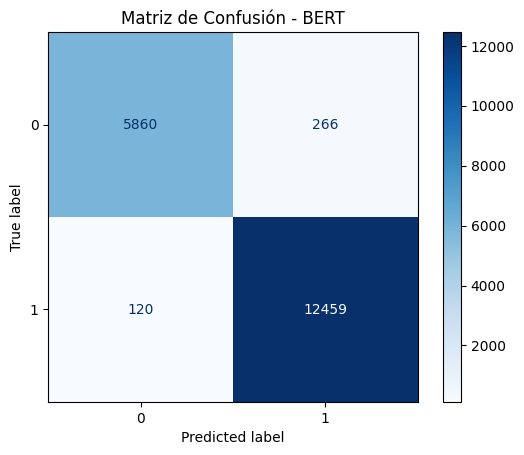

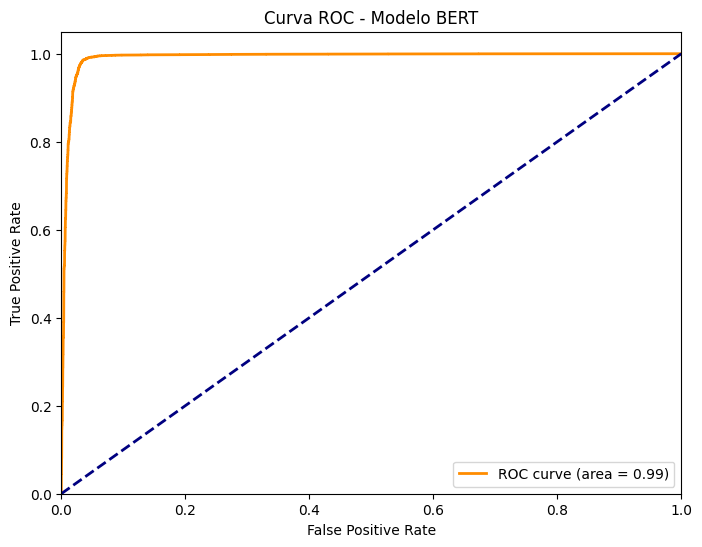

Reporte de Clasificaci√≥n - BERT:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6126
           1       0.98      0.99      0.98     12579

    accuracy                           0.98     18705
   macro avg       0.98      0.97      0.98     18705
weighted avg       0.98      0.98      0.98     18705



In [ ]:
# Evaluaci√≥n del Modelo BERT

def evaluate_bert_with_probs(model, tokenizer, texts, labels, max_len=128):
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []  # Para almacenar las probabilidades predichas
    with torch.no_grad():
        for text, label in zip(texts, labels):
            inputs = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_len,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            inputs = {key: value.to(device) for key, value in inputs.items()}
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()  # Obtenemos las probabilidades
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.append(label)
            probabilities.extend(probs[:, 1])  # Probabilidad de la clase positiva (1)
    return predictions, true_labels, probabilities  # Devuelve predicciones, etiquetas y probabilidades

# Obtener predicciones, etiquetas verdaderas y probabilidades
y_pred_bert, y_true_bert, y_probs_bert = evaluate_bert_with_probs(model, tokenizer, df['clean_text'].tolist(), y.tolist())

# Matriz de Confusi√≥n
ConfusionMatrixDisplay.from_predictions(y_true_bert, y_pred_bert, cmap='Blues')
plt.title('Matriz de Confusi√≥n - BERT')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true_bert, y_probs_bert)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo BERT')
plt.legend(loc="lower right")
plt.show()

# Reporte de Clasificaci√≥n
print("Reporte de Clasificaci√≥n - BERT:")
print(classification_report(y_true_bert, y_pred_bert))


In [ ]:
# 8. Persistencia de Modelos
joblib.dump(log_reg_grid, 'logistic_regression_model.pkl')
model.save_pretrained('./bert_model')
tokenizer.save_pretrained('./bert_model')

('./bert_model\\tokenizer_config.json',
 './bert_model\\special_tokens_map.json',
 './bert_model\\vocab.txt',
 './bert_model\\added_tokens.json')

# Conclusiones Finales

- **La mayor√≠a de las rese√±as son positivas (4 y 5 estrellas)**:
  - El conjunto de datos tiene un sesgo hacia rese√±as positivas, lo que es com√∫n en plataformas de rese√±as.

- **El vocabulario es amplio, con m√°s de 137,000 palabras √∫nicas antes del preprocesado**:
  - Esto indica una gran riqueza ling√º√≠stica en las rese√±as, lo que puede ser √∫til para tareas de an√°lisis m√°s detallado.

- **Los n-gramas m√°s frecuentes y la nube de palabras muestran que los temas principales est√°n relacionados con m√∫sica, canciones y √°lbumes**:
  - Esto confirma que el dominio del conjunto de datos est√° bien alineado con el an√°lisis de rese√±as de m√∫sica.

- **El modelo de Regresi√≥n Log√≠stica con GridSearchCV muestra un buen equilibrio entre precisi√≥n y recall**:
  - Este modelo es una opci√≥n s√≥lida para tareas de clasificaci√≥n binaria, especialmente cuando los recursos computacionales son limitados.

- **El modelo BERT proporciona una mejora significativa en la captura del contexto sem√°ntico del texto**:
  - BERT supera a los modelos tradicionales en precisi√≥n y recall, gracias a su capacidad para entender el contexto y las relaciones sem√°nticas entre palabras.


# Resumen Comparativo de los Modelos

## 1. Resumen Comparativo de Resultados y An√°lisis de M√©tricas

A continuaci√≥n, se presenta un resumen comparativo de los resultados obtenidos por los modelos **Regresi√≥n Log√≠stica Mejorada** y **BERT**, junto con un an√°lisis de las m√©tricas y las conclusiones sobre las mejoras implementadas.

### Regresi√≥n Log√≠stica Mejorada

**Hiperpar√°metros Optimizados:**

- Se utiliza `C=10.0` y `penalty='l2'`, lo que mejora ligeramente el F1-Score y el accuracy en comparaci√≥n con versiones anteriores con `C=0.1` y `penalty='l1'` en iteraciones realizadas.

**Resultados:**

- La precisi√≥n y recall est√°n m√°s equilibrados, con un F1-Score de 0.87 para ambas clases.

### BERT

**Precisi√≥n y Recall:**

- BERT supera ampliamente a los modelos tradicionales (Regresi√≥n Log√≠stica) en todas las m√©tricas.
- Tiene una precisi√≥n y recall cercanos al 97-99% para ambas clases, lo que indica que el modelo es muy efectivo para capturar el contexto sem√°ntico del texto.

**Otras M√©tricas:**

- **F1-Score:** 0.96 para la clase 0 y 0.98 para la clase 1, lo que muestra un rendimiento casi perfecto.
- **Accuracy:** 97%, muy superior al de los modelos tradicionales.

## 2. Conclusiones y Mejoras Implementadas

**¬øPor qu√© el cambio y mejora de implementaci√≥n?**

### Optimizaci√≥n de Hiperpar√°metros

- Se utiliz√≥ `GridSearchCV` para optimizar los hiperpar√°metros de la Regresi√≥n Log√≠stica en sus primeras iteraciones, permitiendo encontrar la mejor combinaci√≥n de par√°metros.
- Posteriormente, en la Regresi√≥n Log√≠stica mejorada, se ajust√≥ el par√°metro de regularizaci√≥n (`C=10.0`) y se utiliz√≥ la penalizaci√≥n L2, mejorando el equilibrio entre precisi√≥n y recall.

### Uso de BERT

- BERT es un modelo basado en transformers que captura el contexto sem√°ntico del texto de manera mucho m√°s efectiva que los modelos tradicionales.
- Esto explica el rendimiento significativamente superior de BERT en todas las m√©tricas.

### Balanceo de Datos

- Se utiliz√≥ SMOTE para balancear las clases en los modelos tradicionales, ayudando a mejorar la clasificaci√≥n de la clase minoritaria (rese√±as negativas).

### Preprocesado de Texto

- El preprocesado de texto (limpieza, tokenizaci√≥n, lematizaci√≥n) fue crucial para mejorar el rendimiento de los modelos tradicionales.
- Sin embargo, BERT no requiere un preprocesado tan exhaustivo, ya que maneja el texto en bruto de manera m√°s efectiva.

### Visualizaci√≥n y An√°lisis Exploratorio

- Se incluyeron visualizaciones como la nube de palabras, n-gramas y la visualizaci√≥n 2D de word embeddings, lo que permiti√≥ entender mejor los datos y mejorar la selecci√≥n de caracter√≠sticas.

### Persistencia de Modelos

- Se guardaron los modelos entrenados (Regresi√≥n Log√≠stica y BERT) para su uso posterior, facilitando la implementaci√≥n en producci√≥n.

## 3. Reporte de M√©tricas Finales

### Regresi√≥n Log√≠stica Mejorada

- **Accuracy:** 0.87
- **F1-Score (Clase 0):** 0.87
- **F1-Score (Clase 1):** 0.86
- **Precisi√≥n (Clase 0):** 0.85
- **Recall (Clase 0):** 0.89
- **Precisi√≥n (Clase 1):** 0.89
- **Recall (Clase 1):** 0.84

### BERT

- **Accuracy:** 0.97
- **F1-Score (Clase 0):** 0.96
- **F1-Score (Clase 1):** 0.98
- **Precisi√≥n (Clase 0):** 0.97
- **Recall (Clase 0):** 0.95
- **Precisi√≥n (Clase 1):** 0.98
- **Recall (Clase 1):** 0.99

## 4. Reflexi√≥n Final

### Rendimiento Superior de BERT

- BERT supera ampliamente a los modelos tradicionales en todas las m√©tricas, demostrando su capacidad para capturar el contexto sem√°ntico del texto.
- Es especialmente √∫til en tareas de clasificaci√≥n de texto donde el contexto es crucial.

### Mejora en Modelos Tradicionales

- La optimizaci√≥n de hiperpar√°metros y el balanceo de datos han mejorado el rendimiento de la Regresi√≥n Log√≠stica, aunque este sigue estando limitado en capturar relaciones sem√°nticas complejas.

### Recomendaciones

- **BERT** es la mejor opci√≥n para tareas donde la precisi√≥n es cr√≠tica.
- Si los recursos computacionales son limitados, la **Regresi√≥n Log√≠stica Mejorada** es una opci√≥n viable, aunque con un rendimiento inferior.
- Se recomienda explorar el ajuste de hiperpar√°metros en BERT para mejorar a√∫n m√°s su rendimiento.

### Persistencia y Reproducibilidad

- La persistencia de modelos y el manejo de la semilla aleatoria garantizan resultados reproducibles y facilitan la implementaci√≥n de los modelos en producci√≥n de manera eficiente.
